In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

In [2]:
#reading raw data
train_values = pd.read_csv('train_values.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
# use the following file to create submission file
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
# use the following file to test your final model, but don't mix up with the test files you create from test
test_values = pd.read_csv('test_values.csv', index_col='building_id')

In [3]:
# i am not good at pandas, so i just the following method to join df
#merge feature and labels to 1 dataset
fullset = pd.merge(train_values,train_labels, on = 'building_id')


In [4]:
# data cleaning for training data
fullset.loc[fullset["age"] == 995, "age"] = 205

In [5]:
#data cleaning for final testing data
test_values.loc[test_values["age"] == 995, "age"] = 205

In [6]:
# data engineering for traning data 
fullset['CntFloorAge'] = fullset['count_floors_pre_eq']/(fullset['age']+0.1)
fullset['CntFloorsArea'] = fullset['count_floors_pre_eq']/fullset['area_percentage']
fullset['CntFloorsHeight'] = fullset['count_floors_pre_eq']/fullset['height_percentage']
fullset['AreaPerAge'] = fullset['area_percentage']/(fullset['age']+0.1)
fullset['HeightPerAge'] = fullset['height_percentage']/(fullset['age']+0.1)
fullset['AreaPerHeight'] = fullset['area_percentage']/fullset['height_percentage']
fullset['CntFamFloors'] = fullset['count_families']/fullset['count_floors_pre_eq']
fullset['CntFamArea'] = fullset['count_families']/fullset['area_percentage']
fullset['CntFamHeight'] = fullset['count_families']/fullset['height_percentage']




In [7]:
# data engineering for testing data 
test_values['CntFloorAge'] = test_values['count_floors_pre_eq']/(test_values['age']+0.1)
test_values['CntFloorsArea'] = test_values['count_floors_pre_eq']/test_values['area_percentage']
test_values['CntFloorsHeight'] = test_values['count_floors_pre_eq']/test_values['height_percentage']
test_values['AreaPerAge'] = test_values['area_percentage']/(test_values['age']+0.1)
test_values['HeightPerAge'] = test_values['height_percentage']/(test_values['age']+0.1)
test_values['AreaPerHeight'] = test_values['area_percentage']/test_values['height_percentage']
test_values['CntFamFloors'] = test_values['count_families']/test_values['count_floors_pre_eq']
test_values['CntFamArea'] = test_values['count_families']/test_values['area_percentage']
test_values['CntFamHeight'] = test_values['count_families']/test_values['height_percentage']

In [8]:
# create X and y for models 
X = fullset.drop('damage_grade', axis = 1)
y = fullset['damage_grade']

In [9]:
# feature selection 
X = X.drop('has_secondary_use_industry', axis = 1)
X = X.drop('has_secondary_use_institution', axis = 1)
X = X.drop('has_secondary_use_school', axis = 1)
X = X.drop('has_secondary_use_health_post', axis = 1)
X = X.drop('has_secondary_use_use_police', axis = 1)
X = X.drop('has_secondary_use_gov_office', axis = 1)

test_values = test_values.drop('has_secondary_use_industry', axis = 1)
test_values = test_values.drop('has_secondary_use_institution', axis = 1)
test_values = test_values.drop('has_secondary_use_school', axis = 1)
test_values = test_values.drop('has_secondary_use_health_post', axis = 1)
test_values = test_values.drop('has_secondary_use_use_police', axis = 1)
test_values = test_values.drop('has_secondary_use_gov_office', axis = 1)

In [10]:
#LGBM can take category values, so you can just make a series and tell it

cat_cols = ['geo_level_1_id','geo_level_2_id','geo_level_3_id','height_percentage','land_surface_condition', 'foundation_type','roof_type','ground_floor_type','other_floor_type',
          'position','plan_configuration','legal_ownership_status']

X[cat_cols] = X[cat_cols].astype('category')

# you need do the same steps for the test data

test_values[cat_cols] = test_values[cat_cols].astype('category')

In [12]:
# i commented these line , because i want to to do CV, but you can put it back to do some quick testing 


# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,stratify=y, random_state =2008)

In [14]:
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import optuna
from optuna.samplers import TPESampler

In [17]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        #"verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 3,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 0.0001, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 0.001, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 150),
        #new setting 
        'verbose': trial.suggest_int('verbose', -2, 10), 
        'max_bin': trial.suggest_int('max_bin', 80, 2000)
    }
    gbm = lgb.LGBMClassifier(**param)
    
    # you can put this back if you want to use holdout method
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    F1 = f1_score(y_test, preds,average='micro')
    return F1
    
    # this is the line i added for CV, but not sure if its correct
#     scores = cross_val_score(gbm, X, y, cv = 3,scoring='f1_micro' )
#     goal = scores.mean()
#     return goal

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1) ## < change this 500 to 1000 once you are ready to find the best combo, but it takes hours to run.



[I 2022-11-26 11:48:47,482] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.5813995435791038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813995435791038
[LightGBM] [Warning] bagging_fraction is set=0.48805353449026784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48805353449026784
[LightGBM] [Warning] lambda_l1 is set=4.6568046379195586e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6568046379195586e-07
[LightGBM] [Warning] lambda_l2 is set=3.995972283135061e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.995972283135061e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5813995435791038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813995435791038
[LightGBM] [Warning] bagging_fraction is set=0.48805353449026784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48805353449026784
[Ligh

[I 2022-11-26 11:48:49,287] Trial 0 finished with value: 0.7108842884825693 and parameters: {'lambda_l1': 4.6568046379195586e-07, 'lambda_l2': 3.995972283135061e-05, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 32, 'verbose': 2, 'max_bin': 842}. Best is trial 0 with value: 0.7108842884825693.


In [15]:
# you use this to save your "study" from optuna

import joblib

#change pkl file name you dont over write the same study file
#joblib.dump(study, "LightGBM 8 with CV - 0.7533 using stratify4.pkl")

In [16]:
# load your study file here: 
study = joblib.load("LightGBM 8 with CV - 0.7533 using stratify4.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.753419926709004
 Params: 
    lambda_l1: 6.791477848292383e-06
    lambda_l2: 8.874795350903507e-06
    num_leaves: 204
    feature_fraction: 0.44790012898348197
    bagging_fraction: 0.8839602086352771
    bagging_freq: 2
    min_child_samples: 119
    verbose: 7
    max_bin: 1786


In [59]:
# dont go back to the pervious block, just run it here, otherwise you are not resuming.
#if you want to continue, you have to do play this line 

study.optimize(objective, n_trials=200) ## < change this 500 to 1000 once you are ready to find the best combo, but it takes hours to run.

[LightGBM] [Warning] feature_fraction is set=0.41205081665296567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205081665296567
[LightGBM] [Warning] bagging_fraction is set=0.9854421783532584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854421783532584
[LightGBM] [Warning] lambda_l1 is set=2.2847659964427038e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2847659964427038e-07
[LightGBM] [Warning] lambda_l2 is set=1.6005321165578808e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6005321165578808e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41205081665296567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205081665296567
[LightGBM] [Warning] bagging_fraction is set=0.9854421783532584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854421783532584
[Li

[I 2022-11-21 21:45:23,287] Trial 700 finished with value: 0.7512902668789933 and parameters: {'lambda_l1': 2.2847659964427038e-07, 'lambda_l2': 1.6005321165578808e-08, 'num_leaves': 38, 'feature_fraction': 0.41205081665296567, 'bagging_fraction': 0.9854421783532584, 'bagging_freq': 4, 'min_child_samples': 23, 'verbose': 3, 'max_bin': 1142}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42399645551659976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42399645551659976
[LightGBM] [Warning] bagging_fraction is set=0.9987769048291915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987769048291915
[LightGBM] [Warning] lambda_l1 is set=2.0086195931737822e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0086195931737822e-07
[LightGBM] [Warning] lambda_l2 is set=1.111146806909552e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.111146806909552e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42399645551659976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42399645551659976
[LightGBM] [Warning] bagging_fraction is set=0.9987769048291915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987769048291915
[Ligh

[I 2022-11-21 21:45:36,649] Trial 701 finished with value: 0.752479806603864 and parameters: {'lambda_l1': 2.0086195931737822e-07, 'lambda_l2': 1.111146806909552e-08, 'num_leaves': 53, 'feature_fraction': 0.42399645551659976, 'bagging_fraction': 0.9987769048291915, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 2, 'max_bin': 967}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4116510989664421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4116510989664421
[LightGBM] [Warning] bagging_fraction is set=0.9998331987875498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998331987875498
[LightGBM] [Warning] lambda_l1 is set=1.6745092364459373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6745092364459373e-07
[LightGBM] [Warning] lambda_l2 is set=4.0804343084077436e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0804343084077436e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4116510989664421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4116510989664421
[LightGBM] [Warning] bagging_fraction is set=0.9998331987875498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998331987875498
[LightG

[I 2022-11-21 21:45:51,867] Trial 702 finished with value: 0.7520768979873755 and parameters: {'lambda_l1': 1.6745092364459373e-07, 'lambda_l2': 4.0804343084077436e-08, 'num_leaves': 43, 'feature_fraction': 0.4116510989664421, 'bagging_fraction': 0.9998331987875498, 'bagging_freq': 4, 'min_child_samples': 25, 'verbose': 3, 'max_bin': 996}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42459559728427326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42459559728427326
[LightGBM] [Warning] bagging_fraction is set=0.9996643767123082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996643767123082
[LightGBM] [Warning] lambda_l1 is set=1.5786259512313146e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5786259512313146e-07
[LightGBM] [Warning] lambda_l2 is set=1.1062125141902683e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1062125141902683e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42459559728427326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42459559728427326
[LightGBM] [Warning] bagging_fraction is set=0.9996643767123082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996643767123082
[Li

[I 2022-11-21 21:46:07,040] Trial 703 finished with value: 0.7526908539744057 and parameters: {'lambda_l1': 1.5786259512313146e-07, 'lambda_l2': 1.1062125141902683e-06, 'num_leaves': 50, 'feature_fraction': 0.42459559728427326, 'bagging_fraction': 0.9996643767123082, 'bagging_freq': 4, 'min_child_samples': 19, 'verbose': 3, 'max_bin': 969}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42197732324044257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42197732324044257
[LightGBM] [Warning] bagging_fraction is set=0.9844459370907318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9844459370907318
[LightGBM] [Warning] lambda_l1 is set=1.5699203871969495e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5699203871969495e-07
[LightGBM] [Warning] lambda_l2 is set=1.3299215447655223e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3299215447655223e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42197732324044257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42197732324044257
[LightGBM] [Warning] bagging_fraction is set=0.9844459370907318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9844459370907318
[Li

[I 2022-11-21 21:46:20,875] Trial 704 finished with value: 0.7522687592333224 and parameters: {'lambda_l1': 1.5699203871969495e-07, 'lambda_l2': 1.3299215447655223e-06, 'num_leaves': 44, 'feature_fraction': 0.42197732324044257, 'bagging_fraction': 0.9844459370907318, 'bagging_freq': 4, 'min_child_samples': 13, 'verbose': 3, 'max_bin': 953}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4302524975142601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302524975142601
[LightGBM] [Warning] bagging_fraction is set=0.9997028080007793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997028080007793
[LightGBM] [Warning] lambda_l1 is set=1.9144867778672968e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9144867778672968e-07
[LightGBM] [Warning] lambda_l2 is set=1.6771412421778485e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6771412421778485e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4302524975142601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302524975142601
[LightGBM] [Warning] bagging_fraction is set=0.9997028080007793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997028080007793
[LightG

[I 2022-11-21 21:46:38,087] Trial 705 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.9144867778672968e-07, 'lambda_l2': 1.6771412421778485e-08, 'num_leaves': 51, 'feature_fraction': 0.4302524975142601, 'bagging_fraction': 0.9997028080007793, 'bagging_freq': 4, 'min_child_samples': 18, 'verbose': 3, 'max_bin': 1173}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43027009113656334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43027009113656334
[LightGBM] [Warning] bagging_fraction is set=0.9807434870238695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807434870238695
[LightGBM] [Warning] lambda_l1 is set=1.5132559653843137e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132559653843137e-07
[LightGBM] [Warning] lambda_l2 is set=1.068867550642387e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.068867550642387e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43027009113656334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43027009113656334
[LightGBM] [Warning] bagging_fraction is set=0.9807434870238695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807434870238695
[Ligh

[I 2022-11-21 21:46:55,247] Trial 706 finished with value: 0.7518274783676445 and parameters: {'lambda_l1': 1.5132559653843137e-07, 'lambda_l2': 1.068867550642387e-06, 'num_leaves': 69, 'feature_fraction': 0.43027009113656334, 'bagging_fraction': 0.9807434870238695, 'bagging_freq': 4, 'min_child_samples': 15, 'verbose': 3, 'max_bin': 979}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41130108202614196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41130108202614196
[LightGBM] [Warning] bagging_fraction is set=0.9904739821617203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904739821617203
[LightGBM] [Warning] lambda_l1 is set=2.281550985356075e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.281550985356075e-07
[LightGBM] [Warning] lambda_l2 is set=1.1022085626155945e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1022085626155945e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41130108202614196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41130108202614196
[LightGBM] [Warning] bagging_fraction is set=0.9904739821617203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904739821617203
[Ligh

[I 2022-11-21 21:47:09,361] Trial 707 finished with value: 0.7522687592333224 and parameters: {'lambda_l1': 2.281550985356075e-07, 'lambda_l2': 1.1022085626155945e-06, 'num_leaves': 49, 'feature_fraction': 0.41130108202614196, 'bagging_fraction': 0.9904739821617203, 'bagging_freq': 4, 'min_child_samples': 20, 'verbose': 2, 'max_bin': 1046}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43011467182353863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43011467182353863
[LightGBM] [Warning] bagging_fraction is set=0.9915919601399856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915919601399856
[LightGBM] [Warning] lambda_l1 is set=3.112513875477287e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.112513875477287e-07
[LightGBM] [Warning] lambda_l2 is set=1.39939028075121e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.39939028075121e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43011467182353863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43011467182353863
[LightGBM] [Warning] bagging_fraction is set=0.9915919601399856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915919601399856
[LightGBM

[I 2022-11-21 21:47:24,791] Trial 708 finished with value: 0.7516164309971028 and parameters: {'lambda_l1': 3.112513875477287e-07, 'lambda_l2': 1.39939028075121e-08, 'num_leaves': 58, 'feature_fraction': 0.43011467182353863, 'bagging_fraction': 0.9915919601399856, 'bagging_freq': 4, 'min_child_samples': 21, 'verbose': 2, 'max_bin': 992}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42357776126842417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42357776126842417
[LightGBM] [Warning] bagging_fraction is set=0.9661394399041152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661394399041152
[LightGBM] [Warning] lambda_l1 is set=1.6413521321972052e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6413521321972052e-07
[LightGBM] [Warning] lambda_l2 is set=8.38015734646153e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.38015734646153e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42357776126842417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42357776126842417
[LightGBM] [Warning] bagging_fraction is set=0.9661394399041152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661394399041152
[LightG

[I 2022-11-21 21:47:40,287] Trial 709 finished with value: 0.7519809673644022 and parameters: {'lambda_l1': 1.6413521321972052e-07, 'lambda_l2': 8.38015734646153e-07, 'num_leaves': 63, 'feature_fraction': 0.42357776126842417, 'bagging_fraction': 0.9661394399041152, 'bagging_freq': 4, 'min_child_samples': 17, 'verbose': 2, 'max_bin': 1023}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4223674642197297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4223674642197297
[LightGBM] [Warning] bagging_fraction is set=0.968039696588834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.968039696588834
[LightGBM] [Warning] lambda_l1 is set=1.525702342828268e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.525702342828268e-07
[LightGBM] [Warning] lambda_l2 is set=7.794227749607568e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.794227749607568e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4223674642197297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4223674642197297
[LightGBM] [Warning] bagging_fraction is set=0.968039696588834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.968039696588834
[LightGBM] [War

[I 2022-11-21 21:47:52,961] Trial 710 finished with value: 0.751539686498724 and parameters: {'lambda_l1': 1.525702342828268e-07, 'lambda_l2': 7.794227749607568e-07, 'num_leaves': 43, 'feature_fraction': 0.4223674642197297, 'bagging_fraction': 0.968039696588834, 'bagging_freq': 4, 'min_child_samples': 20, 'verbose': 1, 'max_bin': 927}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43458528090397747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43458528090397747
[LightGBM] [Warning] bagging_fraction is set=0.9985111409607728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985111409607728
[LightGBM] [Warning] lambda_l1 is set=2.423296818672779e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.423296818672779e-07
[LightGBM] [Warning] lambda_l2 is set=2.81681931858722e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.81681931858722e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43458528090397747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43458528090397747
[LightGBM] [Warning] bagging_fraction is set=0.9985111409607728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985111409607728
[LightGBM

[I 2022-11-21 21:48:09,206] Trial 711 finished with value: 0.7520960841119703 and parameters: {'lambda_l1': 2.423296818672779e-07, 'lambda_l2': 2.81681931858722e-08, 'num_leaves': 55, 'feature_fraction': 0.43458528090397747, 'bagging_fraction': 0.9985111409607728, 'bagging_freq': 4, 'min_child_samples': 23, 'verbose': 3, 'max_bin': 877}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42040911790917074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42040911790917074
[LightGBM] [Warning] bagging_fraction is set=0.9894922675018057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9894922675018057
[LightGBM] [Warning] lambda_l1 is set=2.1235145110791649e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1235145110791649e-07
[LightGBM] [Warning] lambda_l2 is set=1.0289988427748334e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0289988427748334e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42040911790917074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42040911790917074
[LightGBM] [Warning] bagging_fraction is set=0.9894922675018057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9894922675018057
[Li

[I 2022-11-21 21:48:23,846] Trial 712 finished with value: 0.7529019013449475 and parameters: {'lambda_l1': 2.1235145110791649e-07, 'lambda_l2': 1.0289988427748334e-08, 'num_leaves': 52, 'feature_fraction': 0.42040911790917074, 'bagging_fraction': 0.9894922675018057, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 2, 'max_bin': 1068}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4096814529908422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4096814529908422
[LightGBM] [Warning] bagging_fraction is set=0.42004203537666945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42004203537666945
[LightGBM] [Warning] lambda_l1 is set=1.5933149740513002e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5933149740513002e-07
[LightGBM] [Warning] lambda_l2 is set=2.185511939405312e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.185511939405312e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4096814529908422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4096814529908422
[LightGBM] [Warning] bagging_fraction is set=0.42004203537666945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42004203537666945
[Ligh

[I 2022-11-21 21:48:34,597] Trial 713 finished with value: 0.7486425816849254 and parameters: {'lambda_l1': 1.5933149740513002e-07, 'lambda_l2': 2.185511939405312e-08, 'num_leaves': 48, 'feature_fraction': 0.4096814529908422, 'bagging_fraction': 0.42004203537666945, 'bagging_freq': 4, 'min_child_samples': 10, 'verbose': 2, 'max_bin': 905}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40157159703697337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40157159703697337
[LightGBM] [Warning] bagging_fraction is set=0.9797928283238309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797928283238309
[LightGBM] [Warning] lambda_l1 is set=1.8792569586500068e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8792569586500068e-07
[LightGBM] [Warning] lambda_l2 is set=1.1212350144577662e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1212350144577662e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40157159703697337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40157159703697337
[LightGBM] [Warning] bagging_fraction is set=0.9797928283238309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797928283238309
[Li

[I 2022-11-21 21:48:46,998] Trial 714 finished with value: 0.7516164309971028 and parameters: {'lambda_l1': 1.8792569586500068e-07, 'lambda_l2': 1.1212350144577662e-06, 'num_leaves': 40, 'feature_fraction': 0.40157159703697337, 'bagging_fraction': 0.9797928283238309, 'bagging_freq': 4, 'min_child_samples': 112, 'verbose': 2, 'max_bin': 937}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4210737140160506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4210737140160506
[LightGBM] [Warning] bagging_fraction is set=0.9716717683445946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9716717683445946
[LightGBM] [Warning] lambda_l1 is set=1.7170520630729055e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7170520630729055e-07
[LightGBM] [Warning] lambda_l2 is set=1.1029149120648938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1029149120648938e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4210737140160506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4210737140160506
[LightGBM] [Warning] bagging_fraction is set=0.9716717683445946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9716717683445946
[LightG

[I 2022-11-21 21:49:02,950] Trial 715 finished with value: 0.7520385257381861 and parameters: {'lambda_l1': 1.7170520630729055e-07, 'lambda_l2': 1.1029149120648938e-08, 'num_leaves': 64, 'feature_fraction': 0.4210737140160506, 'bagging_fraction': 0.9716717683445946, 'bagging_freq': 4, 'min_child_samples': 25, 'verbose': 1, 'max_bin': 1040}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43362071735798824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43362071735798824
[LightGBM] [Warning] bagging_fraction is set=0.9995687197046225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995687197046225
[LightGBM] [Warning] lambda_l1 is set=3.8306425424789665e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8306425424789665e-07
[LightGBM] [Warning] lambda_l2 is set=1.7664372500407545e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7664372500407545e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43362071735798824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43362071735798824
[LightGBM] [Warning] bagging_fraction is set=0.9995687197046225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995687197046225
[Li

[I 2022-11-21 21:49:16,861] Trial 716 finished with value: 0.7523646898562959 and parameters: {'lambda_l1': 3.8306425424789665e-07, 'lambda_l2': 1.7664372500407545e-08, 'num_leaves': 52, 'feature_fraction': 0.43362071735798824, 'bagging_fraction': 0.9995687197046225, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 2, 'max_bin': 996}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.5786497089657872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5786497089657872
[LightGBM] [Warning] bagging_fraction is set=0.9578829944020103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578829944020103
[LightGBM] [Warning] lambda_l1 is set=1.1686320851654606e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1686320851654606e-07
[LightGBM] [Warning] lambda_l2 is set=1.097346933532021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.097346933532021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5786497089657872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5786497089657872
[LightGBM] [Warning] bagging_fraction is set=0.9578829944020103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578829944020103
[LightGBM

[I 2022-11-21 21:49:31,909] Trial 717 finished with value: 0.7502925884000691 and parameters: {'lambda_l1': 1.1686320851654606e-07, 'lambda_l2': 1.097346933532021e-08, 'num_leaves': 44, 'feature_fraction': 0.5786497089657872, 'bagging_fraction': 0.9578829944020103, 'bagging_freq': 4, 'min_child_samples': 118, 'verbose': 1, 'max_bin': 841}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43480651311226615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43480651311226615
[LightGBM] [Warning] bagging_fraction is set=0.9855372276860781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9855372276860781
[LightGBM] [Warning] lambda_l1 is set=1.931269840724255e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.931269840724255e-07
[LightGBM] [Warning] lambda_l2 is set=1.3469150198789548e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3469150198789548e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43480651311226615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43480651311226615
[LightGBM] [Warning] bagging_fraction is set=0.9855372276860781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9855372276860781
[Ligh

[I 2022-11-21 21:49:47,056] Trial 718 finished with value: 0.7520577118627807 and parameters: {'lambda_l1': 1.931269840724255e-07, 'lambda_l2': 1.3469150198789548e-08, 'num_leaves': 57, 'feature_fraction': 0.43480651311226615, 'bagging_fraction': 0.9855372276860781, 'bagging_freq': 4, 'min_child_samples': 20, 'verbose': 2, 'max_bin': 1079}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4141763495797358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4141763495797358
[LightGBM] [Warning] bagging_fraction is set=0.9731201920179618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9731201920179618
[LightGBM] [Warning] lambda_l1 is set=1.3652318817774158e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3652318817774158e-07
[LightGBM] [Warning] lambda_l2 is set=8.885610681045213e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885610681045213e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4141763495797358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4141763495797358
[LightGBM] [Warning] bagging_fraction is set=0.9731201920179618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9731201920179618
[LightGBM

[I 2022-11-21 21:50:11,947] Trial 719 finished with value: 0.7509449166362887 and parameters: {'lambda_l1': 1.3652318817774158e-07, 'lambda_l2': 8.885610681045213e-07, 'num_leaves': 189, 'feature_fraction': 0.4141763495797358, 'bagging_fraction': 0.9731201920179618, 'bagging_freq': 4, 'min_child_samples': 106, 'verbose': 3, 'max_bin': 1156}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4215590428973546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4215590428973546
[LightGBM] [Warning] bagging_fraction is set=0.9996638953755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996638953755
[LightGBM] [Warning] lambda_l1 is set=2.7240391973361323e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7240391973361323e-07
[LightGBM] [Warning] lambda_l2 is set=1.0022711681458034e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0022711681458034e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4215590428973546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4215590428973546
[LightGBM] [Warning] bagging_fraction is set=0.9996638953755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996638953755
[LightGBM] [Warning

[I 2022-11-21 21:50:27,950] Trial 720 finished with value: 0.7527484123481898 and parameters: {'lambda_l1': 2.7240391973361323e-07, 'lambda_l2': 1.0022711681458034e-08, 'num_leaves': 55, 'feature_fraction': 0.4215590428973546, 'bagging_fraction': 0.9996638953755, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 2, 'max_bin': 961}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4275453040707426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4275453040707426
[LightGBM] [Warning] bagging_fraction is set=0.9904868359780898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904868359780898
[LightGBM] [Warning] lambda_l1 is set=3.024197039843278e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.024197039843278e-07
[LightGBM] [Warning] lambda_l2 is set=1.0302363732401242e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0302363732401242e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4275453040707426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4275453040707426
[LightGBM] [Warning] bagging_fraction is set=0.9904868359780898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904868359780898
[LightGBM

[I 2022-11-21 21:50:42,475] Trial 721 finished with value: 0.7523646898562959 and parameters: {'lambda_l1': 3.024197039843278e-07, 'lambda_l2': 1.0302363732401242e-08, 'num_leaves': 50, 'feature_fraction': 0.4275453040707426, 'bagging_fraction': 0.9904868359780898, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 2, 'max_bin': 1009}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42930809228793826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42930809228793826
[LightGBM] [Warning] bagging_fraction is set=0.9886742174756223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886742174756223
[LightGBM] [Warning] lambda_l1 is set=2.2716374416950752e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2716374416950752e-07
[LightGBM] [Warning] lambda_l2 is set=1.2577401984878486e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2577401984878486e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42930809228793826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42930809228793826
[LightGBM] [Warning] bagging_fraction is set=0.9886742174756223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886742174756223
[Li

[I 2022-11-21 21:50:57,889] Trial 722 finished with value: 0.7519425951152128 and parameters: {'lambda_l1': 2.2716374416950752e-07, 'lambda_l2': 1.2577401984878486e-08, 'num_leaves': 59, 'feature_fraction': 0.42930809228793826, 'bagging_fraction': 0.9886742174756223, 'bagging_freq': 4, 'min_child_samples': 24, 'verbose': 2, 'max_bin': 963}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42110084051267155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42110084051267155
[LightGBM] [Warning] bagging_fraction is set=0.9878970176226889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9878970176226889
[LightGBM] [Warning] lambda_l1 is set=2.0897347473743025e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0897347473743025e-07
[LightGBM] [Warning] lambda_l2 is set=1.1661221065378728e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1661221065378728e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42110084051267155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42110084051267155
[LightGBM] [Warning] bagging_fraction is set=0.9878970176226889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9878970176226889
[Li

[I 2022-11-21 21:51:13,674] Trial 723 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 2.0897347473743025e-07, 'lambda_l2': 1.1661221065378728e-08, 'num_leaves': 67, 'feature_fraction': 0.42110084051267155, 'bagging_fraction': 0.9878970176226889, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 2, 'max_bin': 909}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43996523213753486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43996523213753486
[LightGBM] [Warning] bagging_fraction is set=0.9818127917165097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9818127917165097
[LightGBM] [Warning] lambda_l1 is set=2.7954370411176363e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7954370411176363e-07
[LightGBM] [Warning] lambda_l2 is set=1.6100194873673183e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6100194873673183e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43996523213753486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43996523213753486
[LightGBM] [Warning] bagging_fraction is set=0.9818127917165097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9818127917165097
[Li

[I 2022-11-21 21:51:30,458] Trial 724 finished with value: 0.7514821281249401 and parameters: {'lambda_l1': 2.7954370411176363e-07, 'lambda_l2': 1.6100194873673183e-06, 'num_leaves': 75, 'feature_fraction': 0.43996523213753486, 'bagging_fraction': 0.9818127917165097, 'bagging_freq': 4, 'min_child_samples': 26, 'verbose': 2, 'max_bin': 965}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4328760048649233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4328760048649233
[LightGBM] [Warning] bagging_fraction is set=0.9994151705580334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994151705580334
[LightGBM] [Warning] lambda_l1 is set=2.1722878687665786e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1722878687665786e-07
[LightGBM] [Warning] lambda_l2 is set=1.4284178056929679e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4284178056929679e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4328760048649233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4328760048649233
[LightGBM] [Warning] bagging_fraction is set=0.9994151705580334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994151705580334
[LightG

[I 2022-11-21 21:51:42,286] Trial 725 finished with value: 0.750676310891963 and parameters: {'lambda_l1': 2.1722878687665786e-07, 'lambda_l2': 1.4284178056929679e-06, 'num_leaves': 30, 'feature_fraction': 0.4328760048649233, 'bagging_fraction': 0.9994151705580334, 'bagging_freq': 4, 'min_child_samples': 22, 'verbose': 2, 'max_bin': 1104}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4243671897663898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4243671897663898
[LightGBM] [Warning] bagging_fraction is set=0.9816504137288661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816504137288661
[LightGBM] [Warning] lambda_l1 is set=1.8279962829817081e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8279962829817081e-07
[LightGBM] [Warning] lambda_l2 is set=1.133643724541572e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.133643724541572e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4243671897663898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4243671897663898
[LightGBM] [Warning] bagging_fraction is set=0.9816504137288661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816504137288661
[LightGBM

[I 2022-11-21 21:51:56,751] Trial 726 finished with value: 0.7528443429711633 and parameters: {'lambda_l1': 1.8279962829817081e-07, 'lambda_l2': 1.133643724541572e-08, 'num_leaves': 50, 'feature_fraction': 0.4243671897663898, 'bagging_fraction': 0.9816504137288661, 'bagging_freq': 4, 'min_child_samples': 31, 'verbose': 2, 'max_bin': 1023}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43490004764981355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43490004764981355
[LightGBM] [Warning] bagging_fraction is set=0.9993985781099696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993985781099696
[LightGBM] [Warning] lambda_l1 is set=2.6496624185180375e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6496624185180375e-07
[LightGBM] [Warning] lambda_l2 is set=1.021225011499935e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.021225011499935e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43490004764981355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43490004764981355
[LightGBM] [Warning] bagging_fraction is set=0.9993985781099696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993985781099696
[Ligh

[I 2022-11-21 21:52:09,556] Trial 727 finished with value: 0.7509065443870993 and parameters: {'lambda_l1': 2.6496624185180375e-07, 'lambda_l2': 1.021225011499935e-08, 'num_leaves': 34, 'feature_fraction': 0.43490004764981355, 'bagging_fraction': 0.9993985781099696, 'bagging_freq': 4, 'min_child_samples': 31, 'verbose': 2, 'max_bin': 1037}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43983741620792405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43983741620792405
[LightGBM] [Warning] bagging_fraction is set=0.9827481182392168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9827481182392168
[LightGBM] [Warning] lambda_l1 is set=2.1240483466576918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1240483466576918e-07
[LightGBM] [Warning] lambda_l2 is set=1.3933284817658696e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3933284817658696e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43983741620792405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43983741620792405
[LightGBM] [Warning] bagging_fraction is set=0.9827481182392168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9827481182392168
[Li

[I 2022-11-21 21:52:23,466] Trial 728 finished with value: 0.750983288885478 and parameters: {'lambda_l1': 2.1240483466576918e-07, 'lambda_l2': 1.3933284817658696e-08, 'num_leaves': 44, 'feature_fraction': 0.43983741620792405, 'bagging_fraction': 0.9827481182392168, 'bagging_freq': 4, 'min_child_samples': 32, 'verbose': 2, 'max_bin': 1048}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4234995881831638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4234995881831638
[LightGBM] [Warning] bagging_fraction is set=0.9874108983894303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874108983894303
[LightGBM] [Warning] lambda_l1 is set=3.214513592712829e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.214513592712829e-07
[LightGBM] [Warning] lambda_l2 is set=1.284080487202255e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.284080487202255e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4234995881831638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4234995881831638
[LightGBM] [Warning] bagging_fraction is set=0.9874108983894303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874108983894303
[LightGBM] 

[I 2022-11-21 21:52:38,220] Trial 729 finished with value: 0.7518082922430499 and parameters: {'lambda_l1': 3.214513592712829e-07, 'lambda_l2': 1.284080487202255e-08, 'num_leaves': 50, 'feature_fraction': 0.4234995881831638, 'bagging_fraction': 0.9874108983894303, 'bagging_freq': 4, 'min_child_samples': 30, 'verbose': 2, 'max_bin': 947}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4399593464798793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4399593464798793
[LightGBM] [Warning] bagging_fraction is set=0.9899584933537606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9899584933537606
[LightGBM] [Warning] lambda_l1 is set=4.239847237351073e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.239847237351073e-07
[LightGBM] [Warning] lambda_l2 is set=1.0507518810286672e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0507518810286672e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4399593464798793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4399593464798793
[LightGBM] [Warning] bagging_fraction is set=0.9899584933537606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9899584933537606
[LightGBM

[I 2022-11-21 21:52:51,555] Trial 730 finished with value: 0.7516164309971028 and parameters: {'lambda_l1': 4.239847237351073e-07, 'lambda_l2': 1.0507518810286672e-08, 'num_leaves': 36, 'feature_fraction': 0.4399593464798793, 'bagging_fraction': 0.9899584933537606, 'bagging_freq': 4, 'min_child_samples': 28, 'verbose': 2, 'max_bin': 1025}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42268859272245385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42268859272245385
[LightGBM] [Warning] bagging_fraction is set=0.9800426871913128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9800426871913128
[LightGBM] [Warning] lambda_l1 is set=1.6965287460570726e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6965287460570726e-07
[LightGBM] [Warning] lambda_l2 is set=1.8833767844168368e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8833767844168368e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42268859272245385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42268859272245385
[LightGBM] [Warning] bagging_fraction is set=0.9800426871913128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9800426871913128
[Li

[I 2022-11-21 21:53:06,006] Trial 731 finished with value: 0.7520193396135915 and parameters: {'lambda_l1': 1.6965287460570726e-07, 'lambda_l2': 1.8833767844168368e-08, 'num_leaves': 61, 'feature_fraction': 0.42268859272245385, 'bagging_fraction': 0.9800426871913128, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 2, 'max_bin': 992}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43927798572170934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43927798572170934
[LightGBM] [Warning] bagging_fraction is set=0.9896697228782962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896697228782962
[LightGBM] [Warning] lambda_l1 is set=2.306696607370357e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.306696607370357e-07
[LightGBM] [Warning] lambda_l2 is set=1.9558950283659513e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9558950283659513e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43927798572170934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43927798572170934
[LightGBM] [Warning] bagging_fraction is set=0.9896697228782962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896697228782962
[Ligh

[I 2022-11-21 21:53:21,716] Trial 732 finished with value: 0.7523455037317013 and parameters: {'lambda_l1': 2.306696607370357e-07, 'lambda_l2': 1.9558950283659513e-08, 'num_leaves': 47, 'feature_fraction': 0.43927798572170934, 'bagging_fraction': 0.9896697228782962, 'bagging_freq': 4, 'min_child_samples': 25, 'verbose': 2, 'max_bin': 815}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42056860824532727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42056860824532727
[LightGBM] [Warning] bagging_fraction is set=0.9995278051836609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995278051836609
[LightGBM] [Warning] lambda_l1 is set=1.4498776267063946e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4498776267063946e-07
[LightGBM] [Warning] lambda_l2 is set=1.3027200137344338e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3027200137344338e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42056860824532727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42056860824532727
[LightGBM] [Warning] bagging_fraction is set=0.9995278051836609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995278051836609
[Li

[I 2022-11-21 21:53:37,135] Trial 733 finished with value: 0.7519425951152128 and parameters: {'lambda_l1': 1.4498776267063946e-07, 'lambda_l2': 1.3027200137344338e-08, 'num_leaves': 57, 'feature_fraction': 0.42056860824532727, 'bagging_fraction': 0.9995278051836609, 'bagging_freq': 4, 'min_child_samples': 31, 'verbose': 2, 'max_bin': 923}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4255214243209953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4255214243209953
[LightGBM] [Warning] bagging_fraction is set=0.9757525481084556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757525481084556
[LightGBM] [Warning] lambda_l1 is set=1.7707813821464717e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7707813821464717e-07
[LightGBM] [Warning] lambda_l2 is set=1.0733785017650735e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0733785017650735e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4255214243209953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4255214243209953
[LightGBM] [Warning] bagging_fraction is set=0.9757525481084556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757525481084556
[LightG

[I 2022-11-21 21:53:51,680] Trial 734 finished with value: 0.7516164309971028 and parameters: {'lambda_l1': 1.7707813821464717e-07, 'lambda_l2': 1.0733785017650735e-08, 'num_leaves': 53, 'feature_fraction': 0.4255214243209953, 'bagging_fraction': 0.9757525481084556, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 2, 'max_bin': 976}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4416788092777694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4416788092777694
[LightGBM] [Warning] bagging_fraction is set=0.9832411289502686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9832411289502686
[LightGBM] [Warning] lambda_l1 is set=1.436360570774149e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.436360570774149e-07
[LightGBM] [Warning] lambda_l2 is set=1.008878560286992e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.008878560286992e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4416788092777694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4416788092777694
[LightGBM] [Warning] bagging_fraction is set=0.9832411289502686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9832411289502686
[LightGBM] 

[I 2022-11-21 21:54:07,820] Trial 735 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.436360570774149e-07, 'lambda_l2': 1.008878560286992e-08, 'num_leaves': 66, 'feature_fraction': 0.4416788092777694, 'bagging_fraction': 0.9832411289502686, 'bagging_freq': 4, 'min_child_samples': 108, 'verbose': 1, 'max_bin': 1076}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43016783955874904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43016783955874904
[LightGBM] [Warning] bagging_fraction is set=0.9746069781512264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9746069781512264
[LightGBM] [Warning] lambda_l1 is set=2.0675531136348086e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0675531136348086e-07
[LightGBM] [Warning] lambda_l2 is set=1.3970996460235236e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3970996460235236e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43016783955874904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43016783955874904
[LightGBM] [Warning] bagging_fraction is set=0.9746069781512264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9746069781512264
[Li

[I 2022-11-21 21:54:23,519] Trial 736 finished with value: 0.7518850367414285 and parameters: {'lambda_l1': 2.0675531136348086e-07, 'lambda_l2': 1.3970996460235236e-08, 'num_leaves': 60, 'feature_fraction': 0.43016783955874904, 'bagging_fraction': 0.9746069781512264, 'bagging_freq': 4, 'min_child_samples': 32, 'verbose': 2, 'max_bin': 873}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4160323233086711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4160323233086711
[LightGBM] [Warning] bagging_fraction is set=0.9895324795186349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9895324795186349
[LightGBM] [Warning] lambda_l1 is set=2.4066241634465836e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4066241634465836e-07
[LightGBM] [Warning] lambda_l2 is set=1.7432553683264233e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7432553683264233e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4160323233086711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4160323233086711
[LightGBM] [Warning] bagging_fraction is set=0.9895324795186349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9895324795186349
[LightG

[I 2022-11-21 21:54:38,510] Trial 737 finished with value: 0.7517699199938604 and parameters: {'lambda_l1': 2.4066241634465836e-07, 'lambda_l2': 1.7432553683264233e-08, 'num_leaves': 49, 'feature_fraction': 0.4160323233086711, 'bagging_fraction': 0.9895324795186349, 'bagging_freq': 4, 'min_child_samples': 30, 'verbose': 2, 'max_bin': 1123}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43889855224690516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43889855224690516
[LightGBM] [Warning] bagging_fraction is set=0.9997972277306558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997972277306558
[LightGBM] [Warning] lambda_l1 is set=1.6304241756408852e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6304241756408852e-07
[LightGBM] [Warning] lambda_l2 is set=1.4714965892765909e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4714965892765909e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43889855224690516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43889855224690516
[LightGBM] [Warning] bagging_fraction is set=0.9997972277306558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997972277306558
[Li

[I 2022-11-21 21:54:52,138] Trial 738 finished with value: 0.7515205003741295 and parameters: {'lambda_l1': 1.6304241756408852e-07, 'lambda_l2': 1.4714965892765909e-08, 'num_leaves': 39, 'feature_fraction': 0.43889855224690516, 'bagging_fraction': 0.9997972277306558, 'bagging_freq': 4, 'min_child_samples': 24, 'verbose': 2, 'max_bin': 1020}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4144504856872372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4144504856872372
[LightGBM] [Warning] bagging_fraction is set=0.9598881826917182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9598881826917182
[LightGBM] [Warning] lambda_l1 is set=3.281965234551426e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.281965234551426e-07
[LightGBM] [Warning] lambda_l2 is set=1.213909534315488e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.213909534315488e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4144504856872372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4144504856872372
[LightGBM] [Warning] bagging_fraction is set=0.9598881826917182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9598881826917182
[LightGBM] 

[I 2022-11-21 21:55:05,155] Trial 739 finished with value: 0.7514629420003454 and parameters: {'lambda_l1': 3.281965234551426e-07, 'lambda_l2': 1.213909534315488e-08, 'num_leaves': 46, 'feature_fraction': 0.4144504856872372, 'bagging_fraction': 0.9598881826917182, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 1, 'max_bin': 891}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4428714329717318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4428714329717318
[LightGBM] [Warning] bagging_fraction is set=0.9785256118564186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785256118564186
[LightGBM] [Warning] lambda_l1 is set=1.412436749481695e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.412436749481695e-07
[LightGBM] [Warning] lambda_l2 is set=2.4788339825564502e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4788339825564502e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4428714329717318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4428714329717318
[LightGBM] [Warning] bagging_fraction is set=0.9785256118564186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785256118564186
[LightGBM

[I 2022-11-21 21:55:20,575] Trial 740 finished with value: 0.7517507338692657 and parameters: {'lambda_l1': 1.412436749481695e-07, 'lambda_l2': 2.4788339825564502e-08, 'num_leaves': 56, 'feature_fraction': 0.4428714329717318, 'bagging_fraction': 0.9785256118564186, 'bagging_freq': 4, 'min_child_samples': 113, 'verbose': 3, 'max_bin': 955}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4277654561521828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4277654561521828
[LightGBM] [Warning] bagging_fraction is set=0.9896060851609749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896060851609749
[LightGBM] [Warning] lambda_l1 is set=1.8173858233654366e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8173858233654366e-07
[LightGBM] [Warning] lambda_l2 is set=6.014224645046645e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.014224645046645e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4277654561521828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4277654561521828
[LightGBM] [Warning] bagging_fraction is set=0.9896060851609749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896060851609749
[LightGBM

[I 2022-11-21 21:55:36,730] Trial 741 finished with value: 0.7518466644922392 and parameters: {'lambda_l1': 1.8173858233654366e-07, 'lambda_l2': 6.014224645046645e-07, 'num_leaves': 62, 'feature_fraction': 0.4277654561521828, 'bagging_fraction': 0.9896060851609749, 'bagging_freq': 4, 'min_child_samples': 116, 'verbose': 2, 'max_bin': 993}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41973233608755295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41973233608755295
[LightGBM] [Warning] bagging_fraction is set=0.9707654600383905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9707654600383905
[LightGBM] [Warning] lambda_l1 is set=1.1433582561211146e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1433582561211146e-08
[LightGBM] [Warning] lambda_l2 is set=1.5427142262374952e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5427142262374952e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41973233608755295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41973233608755295
[LightGBM] [Warning] bagging_fraction is set=0.9707654600383905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9707654600383905
[Li

[I 2022-11-21 21:55:51,190] Trial 742 finished with value: 0.7516931754954815 and parameters: {'lambda_l1': 1.1433582561211146e-08, 'lambda_l2': 1.5427142262374952e-08, 'num_leaves': 51, 'feature_fraction': 0.41973233608755295, 'bagging_fraction': 0.9707654600383905, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 2, 'max_bin': 1075}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4437594746121896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4437594746121896
[LightGBM] [Warning] bagging_fraction is set=0.9997623232428889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997623232428889
[LightGBM] [Warning] lambda_l1 is set=2.766960885752672e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.766960885752672e-07
[LightGBM] [Warning] lambda_l2 is set=1.4680127872999851e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4680127872999851e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4437594746121896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4437594746121896
[LightGBM] [Warning] bagging_fraction is set=0.9997623232428889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997623232428889
[LightGBM

[I 2022-11-21 21:56:05,844] Trial 743 finished with value: 0.7520193396135915 and parameters: {'lambda_l1': 2.766960885752672e-07, 'lambda_l2': 1.4680127872999851e-08, 'num_leaves': 44, 'feature_fraction': 0.4437594746121896, 'bagging_fraction': 0.9997623232428889, 'bagging_freq': 5, 'min_child_samples': 25, 'verbose': 2, 'max_bin': 908}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4310239892767458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4310239892767458
[LightGBM] [Warning] bagging_fraction is set=0.9794757041126171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9794757041126171
[LightGBM] [Warning] lambda_l1 is set=1.1876909110435575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1876909110435575e-07
[LightGBM] [Warning] lambda_l2 is set=1.7960108437679213e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7960108437679213e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4310239892767458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4310239892767458
[LightGBM] [Warning] bagging_fraction is set=0.9794757041126171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9794757041126171
[LightG

[I 2022-11-21 21:56:21,474] Trial 744 finished with value: 0.7513861975019666 and parameters: {'lambda_l1': 1.1876909110435575e-07, 'lambda_l2': 1.7960108437679213e-08, 'num_leaves': 56, 'feature_fraction': 0.4310239892767458, 'bagging_fraction': 0.9794757041126171, 'bagging_freq': 4, 'min_child_samples': 33, 'verbose': 3, 'max_bin': 1039}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40000568309043066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40000568309043066
[LightGBM] [Warning] bagging_fraction is set=0.955159947244559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.955159947244559
[LightGBM] [Warning] lambda_l1 is set=2.0700151748758354e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0700151748758354e-07
[LightGBM] [Warning] lambda_l2 is set=1.494060185839352e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.494060185839352e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40000568309043066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40000568309043066
[LightGBM] [Warning] bagging_fraction is set=0.955159947244559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.955159947244559
[LightGBM

[I 2022-11-21 21:56:36,799] Trial 745 finished with value: 0.7515780587479135 and parameters: {'lambda_l1': 2.0700151748758354e-07, 'lambda_l2': 1.494060185839352e-08, 'num_leaves': 67, 'feature_fraction': 0.40000568309043066, 'bagging_fraction': 0.955159947244559, 'bagging_freq': 4, 'min_child_samples': 119, 'verbose': 1, 'max_bin': 989}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.6440731499594654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6440731499594654
[LightGBM] [Warning] bagging_fraction is set=0.9640974783163647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9640974783163647
[LightGBM] [Warning] lambda_l1 is set=1.842455730830763e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.842455730830763e-06
[LightGBM] [Warning] lambda_l2 is set=1.4418133942182934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4418133942182934e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6440731499594654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6440731499594654
[LightGBM] [Warning] bagging_fraction is set=0.9640974783163647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9640974783163647
[LightGBM

[I 2022-11-21 21:56:52,874] Trial 746 finished with value: 0.7506571247673682 and parameters: {'lambda_l1': 1.842455730830763e-06, 'lambda_l2': 1.4418133942182934e-08, 'num_leaves': 51, 'feature_fraction': 0.6440731499594654, 'bagging_fraction': 0.9640974783163647, 'bagging_freq': 4, 'min_child_samples': 28, 'verbose': 4, 'max_bin': 1180}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.9636697854088512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9636697854088512
[LightGBM] [Warning] bagging_fraction is set=0.9828039959279742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828039959279742
[LightGBM] [Warning] lambda_l1 is set=1.4701280420788372e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4701280420788372e-07
[LightGBM] [Warning] lambda_l2 is set=1.5378075456935478e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5378075456935478e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9636697854088512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9636697854088512
[LightGBM] [Warning] bagging_fraction is set=0.9828039959279742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828039959279742
[LightG

[I 2022-11-21 21:57:12,674] Trial 747 finished with value: 0.7496018879146601 and parameters: {'lambda_l1': 1.4701280420788372e-07, 'lambda_l2': 1.5378075456935478e-08, 'num_leaves': 61, 'feature_fraction': 0.9636697854088512, 'bagging_fraction': 0.9828039959279742, 'bagging_freq': 4, 'min_child_samples': 23, 'verbose': 1, 'max_bin': 926}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41499139573699184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41499139573699184
[LightGBM] [Warning] bagging_fraction is set=0.6443842624624528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6443842624624528
[LightGBM] [Warning] lambda_l1 is set=2.4012744539843436e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4012744539843436e-07
[LightGBM] [Warning] lambda_l2 is set=2.317753381141695e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.317753381141695e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41499139573699184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41499139573699184
[LightGBM] [Warning] bagging_fraction is set=0.6443842624624528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6443842624624528
[Ligh

[I 2022-11-21 21:57:24,459] Trial 748 finished with value: 0.749985610406554 and parameters: {'lambda_l1': 2.4012744539843436e-07, 'lambda_l2': 2.317753381141695e-08, 'num_leaves': 44, 'feature_fraction': 0.41499139573699184, 'bagging_fraction': 0.6443842624624528, 'bagging_freq': 4, 'min_child_samples': 31, 'verbose': 3, 'max_bin': 966}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4003571253348927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4003571253348927
[LightGBM] [Warning] bagging_fraction is set=0.9889600122567942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889600122567942
[LightGBM] [Warning] lambda_l1 is set=1.7733371402423855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7733371402423855e-07
[LightGBM] [Warning] lambda_l2 is set=1.2589625364419577e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2589625364419577e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4003571253348927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4003571253348927
[LightGBM] [Warning] bagging_fraction is set=0.9889600122567942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889600122567942
[LightG

[I 2022-11-21 21:57:40,029] Trial 749 finished with value: 0.752479806603864 and parameters: {'lambda_l1': 1.7733371402423855e-07, 'lambda_l2': 1.2589625364419577e-08, 'num_leaves': 71, 'feature_fraction': 0.4003571253348927, 'bagging_fraction': 0.9889600122567942, 'bagging_freq': 4, 'min_child_samples': 22, 'verbose': 2, 'max_bin': 1127}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4323177867748657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4323177867748657
[LightGBM] [Warning] bagging_fraction is set=0.9704751807983759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9704751807983759
[LightGBM] [Warning] lambda_l1 is set=1.3061285553234722e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3061285553234722e-07
[LightGBM] [Warning] lambda_l2 is set=1.0475084728390243e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0475084728390243e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4323177867748657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4323177867748657
[LightGBM] [Warning] bagging_fraction is set=0.9704751807983759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9704751807983759
[LightG

[I 2022-11-21 21:57:55,419] Trial 750 finished with value: 0.7514821281249401 and parameters: {'lambda_l1': 1.3061285553234722e-07, 'lambda_l2': 1.0475084728390243e-08, 'num_leaves': 53, 'feature_fraction': 0.4323177867748657, 'bagging_fraction': 0.9704751807983759, 'bagging_freq': 4, 'min_child_samples': 123, 'verbose': 2, 'max_bin': 877}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.446512242636952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.446512242636952
[LightGBM] [Warning] bagging_fraction is set=0.9997632475052022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997632475052022
[LightGBM] [Warning] lambda_l1 is set=1.226693046025229e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.226693046025229e-07
[LightGBM] [Warning] lambda_l2 is set=1.121779359412181e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.121779359412181e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.446512242636952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.446512242636952
[LightGBM] [Warning] bagging_fraction is set=0.9997632475052022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997632475052022
[LightGBM] [War

[I 2022-11-21 21:58:12,553] Trial 751 finished with value: 0.7518850367414285 and parameters: {'lambda_l1': 1.226693046025229e-07, 'lambda_l2': 1.121779359412181e-08, 'num_leaves': 63, 'feature_fraction': 0.446512242636952, 'bagging_fraction': 0.9997632475052022, 'bagging_freq': 4, 'min_child_samples': 103, 'verbose': 4, 'max_bin': 794}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41290244284877525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41290244284877525
[LightGBM] [Warning] bagging_fraction is set=0.7021610489344305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7021610489344305
[LightGBM] [Warning] lambda_l1 is set=2.0143045014991042e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0143045014991042e-07
[LightGBM] [Warning] lambda_l2 is set=1.8198961777948425e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8198961777948425e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41290244284877525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41290244284877525
[LightGBM] [Warning] bagging_fraction is set=0.7021610489344305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7021610489344305
[Li

[I 2022-11-21 21:58:29,424] Trial 752 finished with value: 0.7508106137641258 and parameters: {'lambda_l1': 2.0143045014991042e-07, 'lambda_l2': 1.8198961777948425e-06, 'num_leaves': 59, 'feature_fraction': 0.41290244284877525, 'bagging_fraction': 0.7021610489344305, 'bagging_freq': 4, 'min_child_samples': 113, 'verbose': 3, 'max_bin': 1029}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42154115358322575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42154115358322575
[LightGBM] [Warning] bagging_fraction is set=0.6789268332064857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6789268332064857
[LightGBM] [Warning] lambda_l1 is set=1.0049872279917298e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0049872279917298e-08
[LightGBM] [Warning] lambda_l2 is set=1.0798859329433579e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0798859329433579e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.42154115358322575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42154115358322575
[LightGBM] [Warning] bagging_fraction is set=0.6789268332064857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6789268332064857
[Li

[I 2022-11-21 21:58:42,158] Trial 753 finished with value: 0.7505803802689894 and parameters: {'lambda_l1': 1.0049872279917298e-08, 'lambda_l2': 1.0798859329433579e-08, 'num_leaves': 47, 'feature_fraction': 0.42154115358322575, 'bagging_fraction': 0.6789268332064857, 'bagging_freq': 5, 'min_child_samples': 26, 'verbose': 2, 'max_bin': 1095}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43285438021175054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43285438021175054
[LightGBM] [Warning] bagging_fraction is set=0.9792055360894374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9792055360894374
[LightGBM] [Warning] lambda_l1 is set=1.5975495944643904e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5975495944643904e-07
[LightGBM] [Warning] lambda_l2 is set=3.660682512277983e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.660682512277983e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43285438021175054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43285438021175054
[LightGBM] [Warning] bagging_fraction is set=0.9792055360894374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9792055360894374
[Ligh

[I 2022-11-21 21:58:57,503] Trial 754 finished with value: 0.7511559640068302 and parameters: {'lambda_l1': 1.5975495944643904e-07, 'lambda_l2': 3.660682512277983e-08, 'num_leaves': 56, 'feature_fraction': 0.43285438021175054, 'bagging_fraction': 0.9792055360894374, 'bagging_freq': 4, 'min_child_samples': 99, 'verbose': 2, 'max_bin': 944}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4493724457251914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4493724457251914
[LightGBM] [Warning] bagging_fraction is set=0.9585398646643245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9585398646643245
[LightGBM] [Warning] lambda_l1 is set=2.663488654233348e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.663488654233348e-07
[LightGBM] [Warning] lambda_l2 is set=6.948320988536771e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.948320988536771e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4493724457251914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4493724457251914
[LightGBM] [Warning] bagging_fraction is set=0.9585398646643245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9585398646643245
[LightGBM] 

[I 2022-11-21 21:59:14,864] Trial 755 finished with value: 0.7513478252527772 and parameters: {'lambda_l1': 2.663488654233348e-07, 'lambda_l2': 6.948320988536771e-07, 'num_leaves': 74, 'feature_fraction': 0.4493724457251914, 'bagging_fraction': 0.9585398646643245, 'bagging_freq': 4, 'min_child_samples': 128, 'verbose': 4, 'max_bin': 1067}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4119381272510013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4119381272510013
[LightGBM] [Warning] bagging_fraction is set=0.9887405731769437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9887405731769437
[LightGBM] [Warning] lambda_l1 is set=3.593519946422088e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.593519946422088e-07
[LightGBM] [Warning] lambda_l2 is set=1.0205302669492515e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0205302669492515e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4119381272510013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4119381272510013
[LightGBM] [Warning] bagging_fraction is set=0.9887405731769437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9887405731769437
[LightGBM

[I 2022-11-21 21:59:29,268] Trial 756 finished with value: 0.7525757372268376 and parameters: {'lambda_l1': 3.593519946422088e-07, 'lambda_l2': 1.0205302669492515e-08, 'num_leaves': 49, 'feature_fraction': 0.4119381272510013, 'bagging_fraction': 0.9887405731769437, 'bagging_freq': 4, 'min_child_samples': 111, 'verbose': 3, 'max_bin': 955}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41307017031392634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41307017031392634
[LightGBM] [Warning] bagging_fraction is set=0.784472483897489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784472483897489
[LightGBM] [Warning] lambda_l1 is set=4.183837310599106e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.183837310599106e-07
[LightGBM] [Warning] lambda_l2 is set=1.6452083480303178e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6452083480303178e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.41307017031392634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41307017031392634
[LightGBM] [Warning] bagging_fraction is set=0.784472483897489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784472483897489
[LightGBM

[I 2022-11-21 21:59:40,788] Trial 757 finished with value: 0.7510216611346675 and parameters: {'lambda_l1': 4.183837310599106e-07, 'lambda_l2': 1.6452083480303178e-08, 'num_leaves': 39, 'feature_fraction': 0.41307017031392634, 'bagging_fraction': 0.784472483897489, 'bagging_freq': 5, 'min_child_samples': 109, 'verbose': 3, 'max_bin': 953}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4445927157370371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4445927157370371
[LightGBM] [Warning] bagging_fraction is set=0.9712186522907925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712186522907925
[LightGBM] [Warning] lambda_l1 is set=1.3106271529733871e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3106271529733871e-08
[LightGBM] [Warning] lambda_l2 is set=1.42199126193577e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.42199126193577e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4445927157370371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4445927157370371
[LightGBM] [Warning] bagging_fraction is set=0.9712186522907925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712186522907925
[LightGBM] 

[I 2022-11-21 21:59:57,533] Trial 758 finished with value: 0.7516739893708869 and parameters: {'lambda_l1': 1.3106271529733871e-08, 'lambda_l2': 1.42199126193577e-06, 'num_leaves': 66, 'feature_fraction': 0.4445927157370371, 'bagging_fraction': 0.9712186522907925, 'bagging_freq': 4, 'min_child_samples': 115, 'verbose': 2, 'max_bin': 1007}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42935987112100893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42935987112100893
[LightGBM] [Warning] bagging_fraction is set=0.4694929169116785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4694929169116785
[LightGBM] [Warning] lambda_l1 is set=5.500212079776415e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.500212079776415e-05
[LightGBM] [Warning] lambda_l2 is set=7.096983586255212e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.096983586255212e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42935987112100893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42935987112100893
[LightGBM] [Warning] bagging_fraction is set=0.4694929169116785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4694929169116785
[LightG

[I 2022-11-21 22:00:09,308] Trial 759 finished with value: 0.7480286256978953 and parameters: {'lambda_l1': 5.500212079776415e-05, 'lambda_l2': 7.096983586255212e-07, 'num_leaves': 54, 'feature_fraction': 0.42935987112100893, 'bagging_fraction': 0.4694929169116785, 'bagging_freq': 6, 'min_child_samples': 29, 'verbose': 1, 'max_bin': 1023}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4334862900477427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4334862900477427
[LightGBM] [Warning] bagging_fraction is set=0.9995671728664672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995671728664672
[LightGBM] [Warning] lambda_l1 is set=3.22852984615236e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.22852984615236e-07
[LightGBM] [Warning] lambda_l2 is set=1.1156360942718065e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1156360942718065e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4334862900477427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4334862900477427
[LightGBM] [Warning] bagging_fraction is set=0.9995671728664672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995671728664672
[LightGBM] 

[I 2022-11-21 22:00:22,683] Trial 760 finished with value: 0.7524030621054855 and parameters: {'lambda_l1': 3.22852984615236e-07, 'lambda_l2': 1.1156360942718065e-08, 'num_leaves': 41, 'feature_fraction': 0.4334862900477427, 'bagging_fraction': 0.9995671728664672, 'bagging_freq': 4, 'min_child_samples': 108, 'verbose': 3, 'max_bin': 845}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41501344565505643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41501344565505643
[LightGBM] [Warning] bagging_fraction is set=0.9865369125137224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9865369125137224
[LightGBM] [Warning] lambda_l1 is set=2.91267051827883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.91267051827883e-07
[LightGBM] [Warning] lambda_l2 is set=1.9695308267141004e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9695308267141004e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.41501344565505643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41501344565505643
[LightGBM] [Warning] bagging_fraction is set=0.9865369125137224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9865369125137224
[LightG

[I 2022-11-21 22:00:37,278] Trial 761 finished with value: 0.7518466644922392 and parameters: {'lambda_l1': 2.91267051827883e-07, 'lambda_l2': 1.9695308267141004e-08, 'num_leaves': 51, 'feature_fraction': 0.41501344565505643, 'bagging_fraction': 0.9865369125137224, 'bagging_freq': 5, 'min_child_samples': 111, 'verbose': 3, 'max_bin': 936}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.446696722070276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.446696722070276
[LightGBM] [Warning] bagging_fraction is set=0.9890898062261133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9890898062261133
[LightGBM] [Warning] lambda_l1 is set=3.5506531825468806e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5506531825468806e-07
[LightGBM] [Warning] lambda_l2 is set=1.0132348326864515e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0132348326864515e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.446696722070276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.446696722070276
[LightGBM] [Warning] bagging_fraction is set=0.9890898062261133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9890898062261133
[LightGBM] 

[I 2022-11-21 22:00:51,974] Trial 762 finished with value: 0.7520768979873755 and parameters: {'lambda_l1': 3.5506531825468806e-07, 'lambda_l2': 1.0132348326864515e-08, 'num_leaves': 49, 'feature_fraction': 0.446696722070276, 'bagging_fraction': 0.9890898062261133, 'bagging_freq': 4, 'min_child_samples': 115, 'verbose': 4, 'max_bin': 873}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4106642254128507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4106642254128507
[LightGBM] [Warning] bagging_fraction is set=0.9896851315715226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896851315715226
[LightGBM] [Warning] lambda_l1 is set=2.5194619426578813e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5194619426578813e-07
[LightGBM] [Warning] lambda_l2 is set=1.0579315914898801e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0579315914898801e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4106642254128507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4106642254128507
[LightGBM] [Warning] bagging_fraction is set=0.9896851315715226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896851315715226
[LightG

[I 2022-11-21 22:01:05,833] Trial 763 finished with value: 0.7517123616200764 and parameters: {'lambda_l1': 2.5194619426578813e-07, 'lambda_l2': 1.0579315914898801e-08, 'num_leaves': 46, 'feature_fraction': 0.4106642254128507, 'bagging_fraction': 0.9896851315715226, 'bagging_freq': 5, 'min_child_samples': 120, 'verbose': 4, 'max_bin': 971}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42816991470688986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42816991470688986
[LightGBM] [Warning] bagging_fraction is set=0.988894985091511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988894985091511
[LightGBM] [Warning] lambda_l1 is set=7.473546919207114e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.473546919207114e-07
[LightGBM] [Warning] lambda_l2 is set=1.3654635351907921e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3654635351907921e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42816991470688986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42816991470688986
[LightGBM] [Warning] bagging_fraction is set=0.988894985091511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988894985091511
[LightGBM

[I 2022-11-21 22:01:19,198] Trial 764 finished with value: 0.7523838759808905 and parameters: {'lambda_l1': 7.473546919207114e-07, 'lambda_l2': 1.3654635351907921e-08, 'num_leaves': 40, 'feature_fraction': 0.42816991470688986, 'bagging_fraction': 0.988894985091511, 'bagging_freq': 4, 'min_child_samples': 111, 'verbose': 2, 'max_bin': 1048}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42172829165376263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42172829165376263
[LightGBM] [Warning] bagging_fraction is set=0.9639609859298469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9639609859298469
[LightGBM] [Warning] lambda_l1 is set=1.7870194412845198e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7870194412845198e-07
[LightGBM] [Warning] lambda_l2 is set=1.0438027432462811e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0438027432462811e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42172829165376263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42172829165376263
[LightGBM] [Warning] bagging_fraction is set=0.9639609859298469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9639609859298469
[Li

[I 2022-11-21 22:01:41,493] Trial 765 finished with value: 0.7522687592333224 and parameters: {'lambda_l1': 1.7870194412845198e-07, 'lambda_l2': 1.0438027432462811e-06, 'num_leaves': 191, 'feature_fraction': 0.42172829165376263, 'bagging_fraction': 0.9639609859298469, 'bagging_freq': 4, 'min_child_samples': 25, 'verbose': 5, 'max_bin': 1109}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.44388515412429413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44388515412429413
[LightGBM] [Warning] bagging_fraction is set=0.9996376433555716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996376433555716
[LightGBM] [Warning] lambda_l1 is set=2.963834724145613e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.963834724145613e-07
[LightGBM] [Warning] lambda_l2 is set=1.725629314143048e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.725629314143048e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.44388515412429413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44388515412429413
[LightGBM] [Warning] bagging_fraction is set=0.9996376433555716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996376433555716
[LightG

[I 2022-11-21 22:01:55,853] Trial 766 finished with value: 0.75242224823008 and parameters: {'lambda_l1': 2.963834724145613e-07, 'lambda_l2': 1.725629314143048e-08, 'num_leaves': 47, 'feature_fraction': 0.44388515412429413, 'bagging_fraction': 0.9996376433555716, 'bagging_freq': 4, 'min_child_samples': 110, 'verbose': 3, 'max_bin': 915}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4354468704669932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4354468704669932
[LightGBM] [Warning] bagging_fraction is set=0.9747787385130782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9747787385130782
[LightGBM] [Warning] lambda_l1 is set=1.1063906534926322e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1063906534926322e-07
[LightGBM] [Warning] lambda_l2 is set=5.855893358297795e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.855893358297795e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4354468704669932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4354468704669932
[LightGBM] [Warning] bagging_fraction is set=0.9747787385130782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9747787385130782
[LightGBM

[I 2022-11-21 22:02:12,113] Trial 767 finished with value: 0.7528251568465686 and parameters: {'lambda_l1': 1.1063906534926322e-07, 'lambda_l2': 5.855893358297795e-07, 'num_leaves': 58, 'feature_fraction': 0.4354468704669932, 'bagging_fraction': 0.9747787385130782, 'bagging_freq': 4, 'min_child_samples': 34, 'verbose': 2, 'max_bin': 1284}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43400007741408125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43400007741408125
[LightGBM] [Warning] bagging_fraction is set=0.7509499380901179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509499380901179
[LightGBM] [Warning] lambda_l1 is set=1.1425438629980205e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1425438629980205e-07
[LightGBM] [Warning] lambda_l2 is set=1.0214009377109652e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0214009377109652e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.43400007741408125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43400007741408125
[LightGBM] [Warning] bagging_fraction is set=0.7509499380901179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509499380901179
[Li

[I 2022-11-21 22:02:23,808] Trial 768 finished with value: 0.7502734022754743 and parameters: {'lambda_l1': 1.1425438629980205e-07, 'lambda_l2': 1.0214009377109652e-08, 'num_leaves': 35, 'feature_fraction': 0.43400007741408125, 'bagging_fraction': 0.7509499380901179, 'bagging_freq': 6, 'min_child_samples': 115, 'verbose': 2, 'max_bin': 970}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42767687682840333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42767687682840333
[LightGBM] [Warning] bagging_fraction is set=0.982085199233824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.982085199233824
[LightGBM] [Warning] lambda_l1 is set=1.0414335576804399e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0414335576804399e-07
[LightGBM] [Warning] lambda_l2 is set=1.4657020433308758e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4657020433308758e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.42767687682840333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42767687682840333
[LightGBM] [Warning] bagging_fraction is set=0.982085199233824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.982085199233824
[LightG

[I 2022-11-21 22:02:38,213] Trial 769 finished with value: 0.7510600333838567 and parameters: {'lambda_l1': 1.0414335576804399e-07, 'lambda_l2': 1.4657020433308758e-08, 'num_leaves': 48, 'feature_fraction': 0.42767687682840333, 'bagging_fraction': 0.982085199233824, 'bagging_freq': 5, 'min_child_samples': 33, 'verbose': 2, 'max_bin': 1208}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4195866749354254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4195866749354254
[LightGBM] [Warning] bagging_fraction is set=0.9528385724916951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9528385724916951
[LightGBM] [Warning] lambda_l1 is set=8.75264937956499e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.75264937956499e-08
[LightGBM] [Warning] lambda_l2 is set=6.150546832574416e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.150546832574416e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4195866749354254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4195866749354254
[LightGBM] [Warning] bagging_fraction is set=0.9528385724916951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9528385724916951
[LightGBM] [W

[I 2022-11-21 22:02:52,694] Trial 770 finished with value: 0.7508681721379099 and parameters: {'lambda_l1': 8.75264937956499e-08, 'lambda_l2': 6.150546832574416e-07, 'num_leaves': 53, 'feature_fraction': 0.4195866749354254, 'bagging_fraction': 0.9528385724916951, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 2, 'max_bin': 1152}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.449474525648793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.449474525648793
[LightGBM] [Warning] bagging_fraction is set=0.8304066133043883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8304066133043883
[LightGBM] [Warning] lambda_l1 is set=1.3112371234971628e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3112371234971628e-07
[LightGBM] [Warning] lambda_l2 is set=5.297878652421105e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.297878652421105e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.449474525648793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.449474525648793
[LightGBM] [Warning] bagging_fraction is set=0.8304066133043883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8304066133043883
[LightGBM] [W

[I 2022-11-21 22:03:10,308] Trial 771 finished with value: 0.7520768979873755 and parameters: {'lambda_l1': 1.3112371234971628e-07, 'lambda_l2': 5.297878652421105e-07, 'num_leaves': 84, 'feature_fraction': 0.449474525648793, 'bagging_fraction': 0.8304066133043883, 'bagging_freq': 4, 'min_child_samples': 32, 'verbose': 1, 'max_bin': 1280}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4479247207156238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4479247207156238
[LightGBM] [Warning] bagging_fraction is set=0.9725669975420893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725669975420893
[LightGBM] [Warning] lambda_l1 is set=9.920899475547613e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.920899475547613e-08
[LightGBM] [Warning] lambda_l2 is set=5.441638924106601e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.441638924106601e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4479247207156238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4479247207156238
[LightGBM] [Warning] bagging_fraction is set=0.9725669975420893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9725669975420893
[LightGBM] 

[I 2022-11-21 22:03:13,837] Trial 772 finished with value: 0.7047255424876729 and parameters: {'lambda_l1': 9.920899475547613e-08, 'lambda_l2': 5.441638924106601e-07, 'num_leaves': 2, 'feature_fraction': 0.4479247207156238, 'bagging_fraction': 0.9725669975420893, 'bagging_freq': 4, 'min_child_samples': 35, 'verbose': 1, 'max_bin': 1236}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4010874510456861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010874510456861
[LightGBM] [Warning] bagging_fraction is set=0.5909054720015233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5909054720015233
[LightGBM] [Warning] lambda_l1 is set=1.399628171234648e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.399628171234648e-07
[LightGBM] [Warning] lambda_l2 is set=7.305269935361544e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.305269935361544e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4010874510456861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010874510456861
[LightGBM] [Warning] bagging_fraction is set=0.5909054720015233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5909054720015233
[LightGBM] 

[I 2022-11-21 22:03:26,736] Trial 773 finished with value: 0.7519234089906179 and parameters: {'lambda_l1': 1.399628171234648e-07, 'lambda_l2': 7.305269935361544e-07, 'num_leaves': 65, 'feature_fraction': 0.4010874510456861, 'bagging_fraction': 0.5909054720015233, 'bagging_freq': 5, 'min_child_samples': 34, 'verbose': 2, 'max_bin': 422}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4397551208082794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4397551208082794
[LightGBM] [Warning] bagging_fraction is set=0.9607341718651005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607341718651005
[LightGBM] [Warning] lambda_l1 is set=1.0764066251817931e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0764066251817931e-07
[LightGBM] [Warning] lambda_l2 is set=2.062149828898317e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.062149828898317e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4397551208082794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4397551208082794
[LightGBM] [Warning] bagging_fraction is set=0.9607341718651005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607341718651005
[LightGBM

[I 2022-11-21 22:03:50,292] Trial 774 finished with value: 0.7515780587479135 and parameters: {'lambda_l1': 1.0764066251817931e-07, 'lambda_l2': 2.062149828898317e-06, 'num_leaves': 202, 'feature_fraction': 0.4397551208082794, 'bagging_fraction': 0.9607341718651005, 'bagging_freq': 4, 'min_child_samples': 32, 'verbose': 2, 'max_bin': 742}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42306037945635944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42306037945635944
[LightGBM] [Warning] bagging_fraction is set=0.949809152503385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.949809152503385
[LightGBM] [Warning] lambda_l1 is set=1.2658771972846086e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2658771972846086e-07
[LightGBM] [Warning] lambda_l2 is set=6.035217492430269e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.035217492430269e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42306037945635944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42306037945635944
[LightGBM] [Warning] bagging_fraction is set=0.949809152503385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.949809152503385
[LightGBM

[I 2022-11-21 22:04:06,105] Trial 775 finished with value: 0.7520193396135915 and parameters: {'lambda_l1': 1.2658771972846086e-07, 'lambda_l2': 6.035217492430269e-07, 'num_leaves': 60, 'feature_fraction': 0.42306037945635944, 'bagging_fraction': 0.949809152503385, 'bagging_freq': 4, 'min_child_samples': 36, 'verbose': 2, 'max_bin': 361}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4523788414685483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4523788414685483
[LightGBM] [Warning] bagging_fraction is set=0.9760443118046437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9760443118046437
[LightGBM] [Warning] lambda_l1 is set=9.286449710833756e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.286449710833756e-08
[LightGBM] [Warning] lambda_l2 is set=3.2070254618457335e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2070254618457335e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4523788414685483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4523788414685483
[LightGBM] [Warning] bagging_fraction is set=0.9760443118046437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9760443118046437
[LightGBM

[I 2022-11-21 22:04:31,267] Trial 776 finished with value: 0.7523071314825118 and parameters: {'lambda_l1': 9.286449710833756e-08, 'lambda_l2': 3.2070254618457335e-06, 'num_leaves': 185, 'feature_fraction': 0.4523788414685483, 'bagging_fraction': 0.9760443118046437, 'bagging_freq': 4, 'min_child_samples': 101, 'verbose': 2, 'max_bin': 1306}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4088258805943751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4088258805943751
[LightGBM] [Warning] bagging_fraction is set=0.966480490432526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966480490432526
[LightGBM] [Warning] lambda_l1 is set=1.3755090527396864e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3755090527396864e-07
[LightGBM] [Warning] lambda_l2 is set=6.288850324373322e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.288850324373322e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4088258805943751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4088258805943751
[LightGBM] [Warning] bagging_fraction is set=0.966480490432526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966480490432526
[LightGBM] [W

[I 2022-11-21 22:04:46,275] Trial 777 finished with value: 0.7519425951152128 and parameters: {'lambda_l1': 1.3755090527396864e-07, 'lambda_l2': 6.288850324373322e-07, 'num_leaves': 56, 'feature_fraction': 0.4088258805943751, 'bagging_fraction': 0.966480490432526, 'bagging_freq': 4, 'min_child_samples': 41, 'verbose': 2, 'max_bin': 1224}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4346171656737174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4346171656737174
[LightGBM] [Warning] bagging_fraction is set=0.9897153115683874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897153115683874
[LightGBM] [Warning] lambda_l1 is set=2.48362495519624e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.48362495519624e-07
[LightGBM] [Warning] lambda_l2 is set=1.273276326586228e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.273276326586228e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4346171656737174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4346171656737174
[LightGBM] [Warning] bagging_fraction is set=0.9897153115683874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897153115683874
[LightGBM] [W

[I 2022-11-21 22:05:01,347] Trial 778 finished with value: 0.7524606204792694 and parameters: {'lambda_l1': 2.48362495519624e-07, 'lambda_l2': 1.273276326586228e-08, 'num_leaves': 52, 'feature_fraction': 0.4346171656737174, 'bagging_fraction': 0.9897153115683874, 'bagging_freq': 4, 'min_child_samples': 117, 'verbose': 3, 'max_bin': 1011}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4491263046773912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4491263046773912
[LightGBM] [Warning] bagging_fraction is set=0.9801510108520876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9801510108520876
[LightGBM] [Warning] lambda_l1 is set=1.2459579085640383e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2459579085640383e-08
[LightGBM] [Warning] lambda_l2 is set=7.140723819399172e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.140723819399172e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4491263046773912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4491263046773912
[LightGBM] [Warning] bagging_fraction is set=0.9801510108520876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9801510108520876
[LightGBM

[I 2022-11-21 22:05:24,327] Trial 779 finished with value: 0.7510792195084515 and parameters: {'lambda_l1': 1.2459579085640383e-08, 'lambda_l2': 7.140723819399172e-08, 'num_leaves': 209, 'feature_fraction': 0.4491263046773912, 'bagging_fraction': 0.9801510108520876, 'bagging_freq': 4, 'min_child_samples': 30, 'verbose': 0, 'max_bin': 1304}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4369584024074934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4369584024074934
[LightGBM] [Warning] bagging_fraction is set=0.853658901448727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853658901448727
[LightGBM] [Warning] lambda_l1 is set=1.1300592377406897e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1300592377406897e-07
[LightGBM] [Warning] lambda_l2 is set=2.6491907754561083e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6491907754561083e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4369584024074934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4369584024074934
[LightGBM] [Warning] bagging_fraction is set=0.853658901448727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.853658901448727
[LightGBM] 

[I 2022-11-21 22:05:48,507] Trial 780 finished with value: 0.7510792195084515 and parameters: {'lambda_l1': 1.1300592377406897e-07, 'lambda_l2': 2.6491907754561083e-06, 'num_leaves': 192, 'feature_fraction': 0.4369584024074934, 'bagging_fraction': 0.853658901448727, 'bagging_freq': 4, 'min_child_samples': 38, 'verbose': 2, 'max_bin': 1256}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.6189713978001724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189713978001724
[LightGBM] [Warning] bagging_fraction is set=0.9777046213743608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777046213743608
[LightGBM] [Warning] lambda_l1 is set=9.056377278491989e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.056377278491989e-08
[LightGBM] [Warning] lambda_l2 is set=4.507714552594287e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.507714552594287e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6189713978001724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189713978001724
[LightGBM] [Warning] bagging_fraction is set=0.9777046213743608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777046213743608
[LightGBM] 

[I 2022-11-21 22:06:17,562] Trial 781 finished with value: 0.7503501467738531 and parameters: {'lambda_l1': 9.056377278491989e-08, 'lambda_l2': 4.507714552594287e-07, 'num_leaves': 198, 'feature_fraction': 0.6189713978001724, 'bagging_fraction': 0.9777046213743608, 'bagging_freq': 6, 'min_child_samples': 92, 'verbose': 2, 'max_bin': 1243}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.9025930986250987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9025930986250987
[LightGBM] [Warning] bagging_fraction is set=0.9999175519556944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999175519556944
[LightGBM] [Warning] lambda_l1 is set=1.6027795623108231e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6027795623108231e-07
[LightGBM] [Warning] lambda_l2 is set=8.41983903074406e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.41983903074406e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9025930986250987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9025930986250987
[LightGBM] [Warning] bagging_fraction is set=0.9999175519556944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999175519556944
[LightGBM] 

[I 2022-11-21 22:06:49,586] Trial 782 finished with value: 0.7481437424454634 and parameters: {'lambda_l1': 1.6027795623108231e-07, 'lambda_l2': 8.41983903074406e-06, 'num_leaves': 192, 'feature_fraction': 0.9025930986250987, 'bagging_fraction': 0.9999175519556944, 'bagging_freq': 4, 'min_child_samples': 105, 'verbose': 5, 'max_bin': 1338}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4504258247936634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4504258247936634
[LightGBM] [Warning] bagging_fraction is set=0.9626831763096297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9626831763096297
[LightGBM] [Warning] lambda_l1 is set=4.862954454089509e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862954454089509e-07
[LightGBM] [Warning] lambda_l2 is set=4.83917534539562e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.83917534539562e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4504258247936634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4504258247936634
[LightGBM] [Warning] bagging_fraction is set=0.9626831763096297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9626831763096297
[LightGBM] [W

[I 2022-11-21 22:07:14,395] Trial 783 finished with value: 0.7514821281249401 and parameters: {'lambda_l1': 4.862954454089509e-07, 'lambda_l2': 4.83917534539562e-07, 'num_leaves': 206, 'feature_fraction': 0.4504258247936634, 'bagging_fraction': 0.9626831763096297, 'bagging_freq': 4, 'min_child_samples': 121, 'verbose': 1, 'max_bin': 1164}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4230138559533407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4230138559533407
[LightGBM] [Warning] bagging_fraction is set=0.9499614972255913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499614972255913
[LightGBM] [Warning] lambda_l1 is set=1.2203414745648535e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2203414745648535e-07
[LightGBM] [Warning] lambda_l2 is set=7.887705172541307e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.887705172541307e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4230138559533407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4230138559533407
[LightGBM] [Warning] bagging_fraction is set=0.9499614972255913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499614972255913
[LightGBM

[I 2022-11-21 22:07:30,582] Trial 784 finished with value: 0.7516164309971028 and parameters: {'lambda_l1': 1.2203414745648535e-07, 'lambda_l2': 7.887705172541307e-07, 'num_leaves': 77, 'feature_fraction': 0.4230138559533407, 'bagging_fraction': 0.9499614972255913, 'bagging_freq': 4, 'min_child_samples': 26, 'verbose': 2, 'max_bin': 1686}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4384932625245711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384932625245711
[LightGBM] [Warning] bagging_fraction is set=0.9800209397340333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9800209397340333
[LightGBM] [Warning] lambda_l1 is set=1.9549966287435107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9549966287435107e-07
[LightGBM] [Warning] lambda_l2 is set=2.4135960044189954e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4135960044189954e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4384932625245711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384932625245711
[LightGBM] [Warning] bagging_fraction is set=0.9800209397340333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9800209397340333
[LightG

[I 2022-11-21 22:07:54,786] Trial 785 finished with value: 0.7511367778822355 and parameters: {'lambda_l1': 1.9549966287435107e-07, 'lambda_l2': 2.4135960044189954e-06, 'num_leaves': 186, 'feature_fraction': 0.4384932625245711, 'bagging_fraction': 0.9800209397340333, 'bagging_freq': 4, 'min_child_samples': 97, 'verbose': 2, 'max_bin': 1332}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4099386640319577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4099386640319577
[LightGBM] [Warning] bagging_fraction is set=0.9691880731436617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9691880731436617
[LightGBM] [Warning] lambda_l1 is set=1.6100759090333743e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6100759090333743e-07
[LightGBM] [Warning] lambda_l2 is set=1.0261083176736396e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0261083176736396e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4099386640319577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4099386640319577
[LightGBM] [Warning] bagging_fraction is set=0.9691880731436617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9691880731436617
[LightG

[I 2022-11-21 22:08:11,928] Trial 786 finished with value: 0.7517699199938604 and parameters: {'lambda_l1': 1.6100759090333743e-07, 'lambda_l2': 1.0261083176736396e-06, 'num_leaves': 58, 'feature_fraction': 0.4099386640319577, 'bagging_fraction': 0.9691880731436617, 'bagging_freq': 5, 'min_child_samples': 22, 'verbose': 4, 'max_bin': 328}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4222689640020248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4222689640020248
[LightGBM] [Warning] bagging_fraction is set=0.9997743136523017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997743136523017
[LightGBM] [Warning] lambda_l1 is set=2.228228137726498e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.228228137726498e-07
[LightGBM] [Warning] lambda_l2 is set=1.2443069868626968e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2443069868626968e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4222689640020248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4222689640020248
[LightGBM] [Warning] bagging_fraction is set=0.9997743136523017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997743136523017
[LightGBM

[I 2022-11-21 22:08:23,467] Trial 787 finished with value: 0.7517699199938604 and parameters: {'lambda_l1': 2.228228137726498e-07, 'lambda_l2': 1.2443069868626968e-08, 'num_leaves': 40, 'feature_fraction': 0.4222689640020248, 'bagging_fraction': 0.9997743136523017, 'bagging_freq': 4, 'min_child_samples': 111, 'verbose': 1, 'max_bin': 923}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4221362102719436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4221362102719436
[LightGBM] [Warning] bagging_fraction is set=0.9897774308524475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897774308524475
[LightGBM] [Warning] lambda_l1 is set=3.4463219877194905e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4463219877194905e-07
[LightGBM] [Warning] lambda_l2 is set=1.8428451140914445e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8428451140914445e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4221362102719436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4221362102719436
[LightGBM] [Warning] bagging_fraction is set=0.9897774308524475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897774308524475
[LightG

[I 2022-11-21 22:08:37,486] Trial 788 finished with value: 0.7526524817252165 and parameters: {'lambda_l1': 3.4463219877194905e-07, 'lambda_l2': 1.8428451140914445e-08, 'num_leaves': 46, 'feature_fraction': 0.4221362102719436, 'bagging_fraction': 0.9897774308524475, 'bagging_freq': 4, 'min_child_samples': 119, 'verbose': 3, 'max_bin': 987}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4284901265808662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4284901265808662
[LightGBM] [Warning] bagging_fraction is set=0.9865552531837467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9865552531837467
[LightGBM] [Warning] lambda_l1 is set=2.1168001104805645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1168001104805645e-07
[LightGBM] [Warning] lambda_l2 is set=2.538403012420004e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.538403012420004e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4284901265808662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4284901265808662
[LightGBM] [Warning] bagging_fraction is set=0.9865552531837467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9865552531837467
[LightGBM

[I 2022-11-21 22:08:51,501] Trial 789 finished with value: 0.7521152702365649 and parameters: {'lambda_l1': 2.1168001104805645e-07, 'lambda_l2': 2.538403012420004e-08, 'num_leaves': 43, 'feature_fraction': 0.4284901265808662, 'bagging_fraction': 0.9865552531837467, 'bagging_freq': 4, 'min_child_samples': 126, 'verbose': 3, 'max_bin': 1039}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4343922563587946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4343922563587946
[LightGBM] [Warning] bagging_fraction is set=0.9887732980270336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9887732980270336
[LightGBM] [Warning] lambda_l1 is set=2.3659599680289525e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3659599680289525e-07
[LightGBM] [Warning] lambda_l2 is set=1.8363657068953152e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8363657068953152e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4343922563587946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4343922563587946
[LightGBM] [Warning] bagging_fraction is set=0.9887732980270336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9887732980270336
[LightG

[I 2022-11-21 22:09:02,491] Trial 790 finished with value: 0.7502734022754743 and parameters: {'lambda_l1': 2.3659599680289525e-07, 'lambda_l2': 1.8363657068953152e-08, 'num_leaves': 25, 'feature_fraction': 0.4343922563587946, 'bagging_fraction': 0.9887732980270336, 'bagging_freq': 4, 'min_child_samples': 124, 'verbose': 3, 'max_bin': 1075}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4373965962041849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4373965962041849
[LightGBM] [Warning] bagging_fraction is set=0.9904749558507685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904749558507685
[LightGBM] [Warning] lambda_l1 is set=3.1474251398264206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1474251398264206e-07
[LightGBM] [Warning] lambda_l2 is set=2.5123649243200253e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5123649243200253e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4373965962041849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4373965962041849
[LightGBM] [Warning] bagging_fraction is set=0.9904749558507685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904749558507685
[LightG

[I 2022-11-21 22:09:16,821] Trial 791 finished with value: 0.7516548032462922 and parameters: {'lambda_l1': 3.1474251398264206e-07, 'lambda_l2': 2.5123649243200253e-08, 'num_leaves': 46, 'feature_fraction': 0.4373965962041849, 'bagging_fraction': 0.9904749558507685, 'bagging_freq': 4, 'min_child_samples': 118, 'verbose': 4, 'max_bin': 986}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42279429107682187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42279429107682187
[LightGBM] [Warning] bagging_fraction is set=0.9994341321799562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994341321799562
[LightGBM] [Warning] lambda_l1 is set=4.759131631163501e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.759131631163501e-07
[LightGBM] [Warning] lambda_l2 is set=7.15781683796467e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.15781683796467e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.42279429107682187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42279429107682187
[LightGBM] [Warning] bagging_fraction is set=0.9994341321799562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994341321799562
[LightGBM

[I 2022-11-21 22:09:29,421] Trial 792 finished with value: 0.7515588726233188 and parameters: {'lambda_l1': 4.759131631163501e-07, 'lambda_l2': 7.15781683796467e-06, 'num_leaves': 38, 'feature_fraction': 0.42279429107682187, 'bagging_fraction': 0.9994341321799562, 'bagging_freq': 5, 'min_child_samples': 124, 'verbose': 3, 'max_bin': 837}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.44090853437574584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44090853437574584
[LightGBM] [Warning] bagging_fraction is set=0.9769993561332162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769993561332162
[LightGBM] [Warning] lambda_l1 is set=1.4358620346879907e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4358620346879907e-05
[LightGBM] [Warning] lambda_l2 is set=1.994843092427093e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.994843092427093e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.44090853437574584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44090853437574584
[LightGBM] [Warning] bagging_fraction is set=0.9769993561332162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769993561332162
[Ligh

[I 2022-11-21 22:09:45,026] Trial 793 finished with value: 0.7520001534889968 and parameters: {'lambda_l1': 1.4358620346879907e-05, 'lambda_l2': 1.994843092427093e-08, 'num_leaves': 43, 'feature_fraction': 0.44090853437574584, 'bagging_fraction': 0.9769993561332162, 'bagging_freq': 6, 'min_child_samples': 119, 'verbose': 4, 'max_bin': 1001}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42315174670487143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42315174670487143
[LightGBM] [Warning] bagging_fraction is set=0.9885886851634494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9885886851634494
[LightGBM] [Warning] lambda_l1 is set=2.834799162194807e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.834799162194807e-07
[LightGBM] [Warning] lambda_l2 is set=1.448828402344411e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.448828402344411e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42315174670487143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42315174670487143
[LightGBM] [Warning] bagging_fraction is set=0.9885886851634494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9885886851634494
[LightG

[I 2022-11-21 22:10:00,435] Trial 794 finished with value: 0.7518274783676445 and parameters: {'lambda_l1': 2.834799162194807e-07, 'lambda_l2': 1.448828402344411e-08, 'num_leaves': 55, 'feature_fraction': 0.42315174670487143, 'bagging_fraction': 0.9885886851634494, 'bagging_freq': 4, 'min_child_samples': 121, 'verbose': 2, 'max_bin': 498}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4325707214149359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4325707214149359
[LightGBM] [Warning] bagging_fraction is set=0.9781482155085734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781482155085734
[LightGBM] [Warning] lambda_l1 is set=1.9139286299194226e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9139286299194226e-07
[LightGBM] [Warning] lambda_l2 is set=4.6047060604779785e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6047060604779785e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4325707214149359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4325707214149359
[LightGBM] [Warning] bagging_fraction is set=0.9781482155085734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781482155085734
[LightG

[I 2022-11-21 22:10:16,061] Trial 795 finished with value: 0.7517891061184551 and parameters: {'lambda_l1': 1.9139286299194226e-07, 'lambda_l2': 4.6047060604779785e-08, 'num_leaves': 64, 'feature_fraction': 0.4325707214149359, 'bagging_fraction': 0.9781482155085734, 'bagging_freq': 3, 'min_child_samples': 30, 'verbose': 1, 'max_bin': 1117}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4466598449436294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4466598449436294
[LightGBM] [Warning] bagging_fraction is set=0.9994847687769932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994847687769932
[LightGBM] [Warning] lambda_l1 is set=1.913179725601715e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.913179725601715e-07
[LightGBM] [Warning] lambda_l2 is set=2.1548998702609124e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1548998702609124e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4466598449436294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4466598449436294
[LightGBM] [Warning] bagging_fraction is set=0.9994847687769932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994847687769932
[LightGBM

[I 2022-11-21 22:10:30,751] Trial 796 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.913179725601715e-07, 'lambda_l2': 2.1548998702609124e-08, 'num_leaves': 50, 'feature_fraction': 0.4466598449436294, 'bagging_fraction': 0.9994847687769932, 'bagging_freq': 4, 'min_child_samples': 34, 'verbose': 2, 'max_bin': 1021}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4161716552998335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4161716552998335
[LightGBM] [Warning] bagging_fraction is set=0.9709357479024233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709357479024233
[LightGBM] [Warning] lambda_l1 is set=3.921501774116637e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.921501774116637e-07
[LightGBM] [Warning] lambda_l2 is set=1.5691541794801377e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5691541794801377e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4161716552998335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4161716552998335
[LightGBM] [Warning] bagging_fraction is set=0.9709357479024233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709357479024233
[LightGBM

[I 2022-11-21 22:10:42,407] Trial 797 finished with value: 0.7508681721379099 and parameters: {'lambda_l1': 3.921501774116637e-07, 'lambda_l2': 1.5691541794801377e-08, 'num_leaves': 31, 'feature_fraction': 0.4161716552998335, 'bagging_fraction': 0.9709357479024233, 'bagging_freq': 4, 'min_child_samples': 116, 'verbose': 3, 'max_bin': 970}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42659189968443745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42659189968443745
[LightGBM] [Warning] bagging_fraction is set=0.987880547860964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987880547860964
[LightGBM] [Warning] lambda_l1 is set=2.34651089810763e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.34651089810763e-07
[LightGBM] [Warning] lambda_l2 is set=3.074145272797939e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.074145272797939e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42659189968443745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42659189968443745
[LightGBM] [Warning] bagging_fraction is set=0.987880547860964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987880547860964
[LightGBM] [W

[I 2022-11-21 22:10:57,486] Trial 798 finished with value: 0.7522112008595384 and parameters: {'lambda_l1': 2.34651089810763e-07, 'lambda_l2': 3.074145272797939e-08, 'num_leaves': 54, 'feature_fraction': 0.42659189968443745, 'bagging_fraction': 0.987880547860964, 'bagging_freq': 4, 'min_child_samples': 131, 'verbose': 5, 'max_bin': 683}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4414058890215463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4414058890215463
[LightGBM] [Warning] bagging_fraction is set=0.9612446199508935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9612446199508935
[LightGBM] [Warning] lambda_l1 is set=9.970244365493562e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.970244365493562e-08
[LightGBM] [Warning] lambda_l2 is set=1.7076194366913552e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7076194366913552e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4414058890215463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4414058890215463
[LightGBM] [Warning] bagging_fraction is set=0.9612446199508935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9612446199508935
[LightGBM

[I 2022-11-21 22:11:14,500] Trial 799 finished with value: 0.75242224823008 and parameters: {'lambda_l1': 9.970244365493562e-08, 'lambda_l2': 1.7076194366913552e-08, 'num_leaves': 71, 'feature_fraction': 0.4414058890215463, 'bagging_fraction': 0.9612446199508935, 'bagging_freq': 4, 'min_child_samples': 122, 'verbose': 2, 'max_bin': 913}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4188058671239112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4188058671239112
[LightGBM] [Warning] bagging_fraction is set=0.9804660222292798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804660222292798
[LightGBM] [Warning] lambda_l1 is set=1.705799855531423e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.705799855531423e-07
[LightGBM] [Warning] lambda_l2 is set=1.0128737091543092e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0128737091543092e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4188058671239112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4188058671239112
[LightGBM] [Warning] bagging_fraction is set=0.9804660222292798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804660222292798
[LightGBM

[I 2022-11-21 22:11:29,791] Trial 800 finished with value: 0.7519425951152128 and parameters: {'lambda_l1': 1.705799855531423e-07, 'lambda_l2': 1.0128737091543092e-08, 'num_leaves': 58, 'feature_fraction': 0.4188058671239112, 'bagging_fraction': 0.9804660222292798, 'bagging_freq': 5, 'min_child_samples': 118, 'verbose': 2, 'max_bin': 775}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43210508454442187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43210508454442187
[LightGBM] [Warning] bagging_fraction is set=0.7186547499117408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186547499117408
[LightGBM] [Warning] lambda_l1 is set=2.635592008834756e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.635592008834756e-07
[LightGBM] [Warning] lambda_l2 is set=1.3614495018009455e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3614495018009455e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43210508454442187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43210508454442187
[LightGBM] [Warning] bagging_fraction is set=0.7186547499117408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186547499117408
[Ligh

[I 2022-11-21 22:11:45,181] Trial 801 finished with value: 0.7510600333838567 and parameters: {'lambda_l1': 2.635592008834756e-07, 'lambda_l2': 1.3614495018009455e-08, 'num_leaves': 62, 'feature_fraction': 0.43210508454442187, 'bagging_fraction': 0.7186547499117408, 'bagging_freq': 4, 'min_child_samples': 118, 'verbose': 4, 'max_bin': 1085}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4531468103746586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4531468103746586
[LightGBM] [Warning] bagging_fraction is set=0.9996956510409633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996956510409633
[LightGBM] [Warning] lambda_l1 is set=8.220090617958452e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.220090617958452e-08
[LightGBM] [Warning] lambda_l2 is set=9.468670330061115e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.468670330061115e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4531468103746586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4531468103746586
[LightGBM] [Warning] bagging_fraction is set=0.9996956510409633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996956510409633
[LightGBM] 

[I 2022-11-21 22:12:00,445] Trial 802 finished with value: 0.7516739893708869 and parameters: {'lambda_l1': 8.220090617958452e-08, 'lambda_l2': 9.468670330061115e-08, 'num_leaves': 44, 'feature_fraction': 0.4531468103746586, 'bagging_fraction': 0.9996956510409633, 'bagging_freq': 3, 'min_child_samples': 121, 'verbose': 2, 'max_bin': 881}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41107947294119135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41107947294119135
[LightGBM] [Warning] bagging_fraction is set=0.9678515244832011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9678515244832011
[LightGBM] [Warning] lambda_l1 is set=1.0951319950389064e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0951319950389064e-07
[LightGBM] [Warning] lambda_l2 is set=5.833927476620994e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.833927476620994e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41107947294119135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41107947294119135
[LightGBM] [Warning] bagging_fraction is set=0.9678515244832011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9678515244832011
[Ligh

[I 2022-11-21 22:12:15,375] Trial 803 finished with value: 0.7514821281249401 and parameters: {'lambda_l1': 1.0951319950389064e-07, 'lambda_l2': 5.833927476620994e-06, 'num_leaves': 52, 'feature_fraction': 0.41107947294119135, 'bagging_fraction': 0.9678515244832011, 'bagging_freq': 4, 'min_child_samples': 126, 'verbose': 3, 'max_bin': 995}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43216430027642305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43216430027642305
[LightGBM] [Warning] bagging_fraction is set=0.9450330663840877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450330663840877
[LightGBM] [Warning] lambda_l1 is set=2.034666886189882e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.034666886189882e-07
[LightGBM] [Warning] lambda_l2 is set=1.016033529493886e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.016033529493886e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43216430027642305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43216430027642305
[LightGBM] [Warning] bagging_fraction is set=0.9450330663840877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9450330663840877
[LightG

[I 2022-11-21 22:12:29,785] Trial 804 finished with value: 0.7516931754954815 and parameters: {'lambda_l1': 2.034666886189882e-07, 'lambda_l2': 1.016033529493886e-08, 'num_leaves': 49, 'feature_fraction': 0.43216430027642305, 'bagging_fraction': 0.9450330663840877, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': 3, 'max_bin': 397}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.45083158617413144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45083158617413144
[LightGBM] [Warning] bagging_fraction is set=0.9874859919966193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874859919966193
[LightGBM] [Warning] lambda_l1 is set=1.6105343250040792e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105343250040792e-08
[LightGBM] [Warning] lambda_l2 is set=4.922395591476227e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.922395591476227e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.45083158617413144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45083158617413144
[LightGBM] [Warning] bagging_fraction is set=0.9874859919966193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874859919966193
[Ligh

[I 2022-11-21 22:12:52,184] Trial 805 finished with value: 0.7518466644922392 and parameters: {'lambda_l1': 1.6105343250040792e-08, 'lambda_l2': 4.922395591476227e-07, 'num_leaves': 182, 'feature_fraction': 0.45083158617413144, 'bagging_fraction': 0.9874859919966193, 'bagging_freq': 3, 'min_child_samples': 31, 'verbose': 5, 'max_bin': 966}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4175053843776381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4175053843776381
[LightGBM] [Warning] bagging_fraction is set=0.9790757843718844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9790757843718844
[LightGBM] [Warning] lambda_l1 is set=1.1337931719646106e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1337931719646106e-06
[LightGBM] [Warning] lambda_l2 is set=9.12580844482081e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.12580844482081e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4175053843776381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4175053843776381
[LightGBM] [Warning] bagging_fraction is set=0.9790757843718844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9790757843718844
[LightGBM] 

[I 2022-11-21 22:13:10,115] Trial 806 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.1337931719646106e-06, 'lambda_l2': 9.12580844482081e-06, 'num_leaves': 96, 'feature_fraction': 0.4175053843776381, 'bagging_fraction': 0.9790757843718844, 'bagging_freq': 5, 'min_child_samples': 27, 'verbose': 4, 'max_bin': 1183}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4409905715427621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4409905715427621
[LightGBM] [Warning] bagging_fraction is set=0.9593219845666914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9593219845666914
[LightGBM] [Warning] lambda_l1 is set=7.813884230518825e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.813884230518825e-08
[LightGBM] [Warning] lambda_l2 is set=2.0528810471049025e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0528810471049025e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4409905715427621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4409905715427621
[LightGBM] [Warning] bagging_fraction is set=0.9593219845666914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9593219845666914
[LightGBM

[I 2022-11-21 22:13:33,395] Trial 807 finished with value: 0.7519234089906179 and parameters: {'lambda_l1': 7.813884230518825e-08, 'lambda_l2': 2.0528810471049025e-08, 'num_leaves': 179, 'feature_fraction': 0.4409905715427621, 'bagging_fraction': 0.9593219845666914, 'bagging_freq': 4, 'min_child_samples': 31, 'verbose': 2, 'max_bin': 1047}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4242482965958582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4242482965958582
[LightGBM] [Warning] bagging_fraction is set=0.9906266113350106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906266113350106
[LightGBM] [Warning] lambda_l1 is set=1.2644167202752507e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2644167202752507e-07
[LightGBM] [Warning] lambda_l2 is set=5.380677567674919e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.380677567674919e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4242482965958582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4242482965958582
[LightGBM] [Warning] bagging_fraction is set=0.9906266113350106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906266113350106
[LightGBM

[I 2022-11-21 22:13:45,762] Trial 808 finished with value: 0.7522687592333224 and parameters: {'lambda_l1': 1.2644167202752507e-07, 'lambda_l2': 5.380677567674919e-06, 'num_leaves': 45, 'feature_fraction': 0.4242482965958582, 'bagging_fraction': 0.9906266113350106, 'bagging_freq': 4, 'min_child_samples': 35, 'verbose': 1, 'max_bin': 938}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41244504655246395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41244504655246395
[LightGBM] [Warning] bagging_fraction is set=0.976098551158296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.976098551158296
[LightGBM] [Warning] lambda_l1 is set=1.013244801252737e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.013244801252737e-08
[LightGBM] [Warning] lambda_l2 is set=6.57317214126944e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.57317214126944e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41244504655246395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41244504655246395
[LightGBM] [Warning] bagging_fraction is set=0.976098551158296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.976098551158296
[LightGBM] [W

[I 2022-11-21 22:14:01,400] Trial 809 finished with value: 0.7526141094760269 and parameters: {'lambda_l1': 1.013244801252737e-08, 'lambda_l2': 6.57317214126944e-08, 'num_leaves': 57, 'feature_fraction': 0.41244504655246395, 'bagging_fraction': 0.976098551158296, 'bagging_freq': 4, 'min_child_samples': 114, 'verbose': 2, 'max_bin': 1003}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40984280703375536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40984280703375536
[LightGBM] [Warning] bagging_fraction is set=0.9454159436471835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454159436471835
[LightGBM] [Warning] lambda_l1 is set=1.1872159797249529e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1872159797249529e-08
[LightGBM] [Warning] lambda_l2 is set=5.3743794959225864e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3743794959225864e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40984280703375536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40984280703375536
[LightGBM] [Warning] bagging_fraction is set=0.9454159436471835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454159436471835
[Li

[I 2022-11-21 22:14:17,505] Trial 810 finished with value: 0.7511559640068302 and parameters: {'lambda_l1': 1.1872159797249529e-08, 'lambda_l2': 5.3743794959225864e-08, 'num_leaves': 65, 'feature_fraction': 0.40984280703375536, 'bagging_fraction': 0.9454159436471835, 'bagging_freq': 4, 'min_child_samples': 115, 'verbose': 2, 'max_bin': 982}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.6658151501185753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6658151501185753
[LightGBM] [Warning] bagging_fraction is set=0.9583961298654358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583961298654358
[LightGBM] [Warning] lambda_l1 is set=1.016626542665377e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016626542665377e-08
[LightGBM] [Warning] lambda_l2 is set=1.2719147409331044e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2719147409331044e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6658151501185753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6658151501185753
[LightGBM] [Warning] bagging_fraction is set=0.9583961298654358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583961298654358
[LightGBM

[I 2022-11-21 22:14:35,060] Trial 811 finished with value: 0.7504077051476372 and parameters: {'lambda_l1': 1.016626542665377e-08, 'lambda_l2': 1.2719147409331044e-07, 'num_leaves': 58, 'feature_fraction': 0.6658151501185753, 'bagging_fraction': 0.9583961298654358, 'bagging_freq': 4, 'min_child_samples': 115, 'verbose': 2, 'max_bin': 1007}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41044945479442135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41044945479442135
[LightGBM] [Warning] bagging_fraction is set=0.9689121031550182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9689121031550182
[LightGBM] [Warning] lambda_l1 is set=1.3532514606331995e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3532514606331995e-08
[LightGBM] [Warning] lambda_l2 is set=1.764740201379928e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.764740201379928e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41044945479442135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41044945479442135
[LightGBM] [Warning] bagging_fraction is set=0.9689121031550182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9689121031550182
[Ligh

[I 2022-11-21 22:14:51,812] Trial 812 finished with value: 0.7515588726233188 and parameters: {'lambda_l1': 1.3532514606331995e-08, 'lambda_l2': 1.764740201379928e-08, 'num_leaves': 70, 'feature_fraction': 0.41044945479442135, 'bagging_fraction': 0.9689121031550182, 'bagging_freq': 4, 'min_child_samples': 117, 'verbose': 2, 'max_bin': 1051}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41200218880880285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41200218880880285
[LightGBM] [Warning] bagging_fraction is set=0.968495975872791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.968495975872791
[LightGBM] [Warning] lambda_l1 is set=1.1196345215902426e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1196345215902426e-08
[LightGBM] [Warning] lambda_l2 is set=7.723380790981559e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.723380790981559e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41200218880880285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41200218880880285
[LightGBM] [Warning] bagging_fraction is set=0.968495975872791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.968495975872791
[LightGBM

[I 2022-11-21 22:15:07,285] Trial 813 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.1196345215902426e-08, 'lambda_l2': 7.723380790981559e-08, 'num_leaves': 56, 'feature_fraction': 0.41200218880880285, 'bagging_fraction': 0.968495975872791, 'bagging_freq': 4, 'min_child_samples': 115, 'verbose': 2, 'max_bin': 1084}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40139987383494696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40139987383494696
[LightGBM] [Warning] bagging_fraction is set=0.9553071168166816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553071168166816
[LightGBM] [Warning] lambda_l1 is set=1.1604537655300887e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1604537655300887e-08
[LightGBM] [Warning] lambda_l2 is set=1.0640237230912109e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0640237230912109e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40139987383494696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40139987383494696
[LightGBM] [Warning] bagging_fraction is set=0.9553071168166816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553071168166816
[Li

[I 2022-11-21 22:15:21,204] Trial 814 finished with value: 0.7516548032462922 and parameters: {'lambda_l1': 1.1604537655300887e-08, 'lambda_l2': 1.0640237230912109e-07, 'num_leaves': 53, 'feature_fraction': 0.40139987383494696, 'bagging_fraction': 0.9553071168166816, 'bagging_freq': 4, 'min_child_samples': 113, 'verbose': 2, 'max_bin': 1040}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4540702966884674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4540702966884674
[LightGBM] [Warning] bagging_fraction is set=0.9893149594741911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893149594741911
[LightGBM] [Warning] lambda_l1 is set=1.5756980032601876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5756980032601876e-07
[LightGBM] [Warning] lambda_l2 is set=1.2323312591348663e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2323312591348663e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4540702966884674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4540702966884674
[LightGBM] [Warning] bagging_fraction is set=0.9893149594741911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893149594741911
[LightG

[I 2022-11-21 22:15:45,510] Trial 815 finished with value: 0.7523455037317013 and parameters: {'lambda_l1': 1.5756980032601876e-07, 'lambda_l2': 1.2323312591348663e-08, 'num_leaves': 213, 'feature_fraction': 0.4540702966884674, 'bagging_fraction': 0.9893149594741911, 'bagging_freq': 6, 'min_child_samples': 26, 'verbose': 5, 'max_bin': 900}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40014507527794296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40014507527794296
[LightGBM] [Warning] bagging_fraction is set=0.9765110913165388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9765110913165388
[LightGBM] [Warning] lambda_l1 is set=1.3870144849339237e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3870144849339237e-08
[LightGBM] [Warning] lambda_l2 is set=2.4189348572873447e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4189348572873447e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40014507527794296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40014507527794296
[LightGBM] [Warning] bagging_fraction is set=0.9765110913165388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9765110913165388
[Li

[I 2022-11-21 22:16:00,842] Trial 816 finished with value: 0.752479806603864 and parameters: {'lambda_l1': 1.3870144849339237e-08, 'lambda_l2': 2.4189348572873447e-08, 'num_leaves': 59, 'feature_fraction': 0.40014507527794296, 'bagging_fraction': 0.9765110913165388, 'bagging_freq': 4, 'min_child_samples': 112, 'verbose': 2, 'max_bin': 1014}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41983522388162037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41983522388162037
[LightGBM] [Warning] bagging_fraction is set=0.9784951885025541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784951885025541
[LightGBM] [Warning] lambda_l1 is set=1.0321226457871539e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0321226457871539e-08
[LightGBM] [Warning] lambda_l2 is set=3.0777375248757267e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0777375248757267e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41983522388162037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41983522388162037
[LightGBM] [Warning] bagging_fraction is set=0.9784951885025541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784951885025541
[Li

[I 2022-11-21 22:16:13,459] Trial 817 finished with value: 0.7511943362560195 and parameters: {'lambda_l1': 1.0321226457871539e-08, 'lambda_l2': 3.0777375248757267e-08, 'num_leaves': 36, 'feature_fraction': 0.41983522388162037, 'bagging_fraction': 0.9784951885025541, 'bagging_freq': 4, 'min_child_samples': 118, 'verbose': 2, 'max_bin': 963}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.6897402485762488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6897402485762488
[LightGBM] [Warning] bagging_fraction is set=0.9640862285345617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9640862285345617
[LightGBM] [Warning] lambda_l1 is set=1.0138183366858274e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0138183366858274e-08
[LightGBM] [Warning] lambda_l2 is set=7.960943946701508e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.960943946701508e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6897402485762488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6897402485762488
[LightGBM] [Warning] bagging_fraction is set=0.9640862285345617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9640862285345617
[LightGBM

[I 2022-11-21 22:16:30,104] Trial 818 finished with value: 0.7504268912722319 and parameters: {'lambda_l1': 1.0138183366858274e-08, 'lambda_l2': 7.960943946701508e-08, 'num_leaves': 55, 'feature_fraction': 0.6897402485762488, 'bagging_fraction': 0.9640862285345617, 'bagging_freq': 4, 'min_child_samples': 6, 'verbose': 3, 'max_bin': 1128}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.8348229778269421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8348229778269421
[LightGBM] [Warning] bagging_fraction is set=0.9996315648395956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996315648395956
[LightGBM] [Warning] lambda_l1 is set=1.3028611790557817e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3028611790557817e-08
[LightGBM] [Warning] lambda_l2 is set=4.778868214351398e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.778868214351398e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8348229778269421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8348229778269421
[LightGBM] [Warning] bagging_fraction is set=0.9996315648395956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996315648395956
[LightGBM

[I 2022-11-21 22:16:49,062] Trial 819 finished with value: 0.7503117745246638 and parameters: {'lambda_l1': 1.3028611790557817e-08, 'lambda_l2': 4.778868214351398e-06, 'num_leaves': 62, 'feature_fraction': 0.8348229778269421, 'bagging_fraction': 0.9996315648395956, 'bagging_freq': 4, 'min_child_samples': 120, 'verbose': 1, 'max_bin': 940}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.5974276376410073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5974276376410073
[LightGBM] [Warning] bagging_fraction is set=0.9421843621037407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9421843621037407
[LightGBM] [Warning] lambda_l1 is set=1.4322530312566802e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4322530312566802e-08
[LightGBM] [Warning] lambda_l2 is set=5.1653721806426903e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1653721806426903e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5974276376410073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5974276376410073
[LightGBM] [Warning] bagging_fraction is set=0.9421843621037407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9421843621037407
[LightG

[I 2022-11-21 22:17:09,824] Trial 820 finished with value: 0.7508681721379099 and parameters: {'lambda_l1': 1.4322530312566802e-08, 'lambda_l2': 5.1653721806426903e-08, 'num_leaves': 66, 'feature_fraction': 0.5974276376410073, 'bagging_fraction': 0.9421843621037407, 'bagging_freq': 4, 'min_child_samples': 121, 'verbose': 3, 'max_bin': 1064}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42210124492373197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42210124492373197
[LightGBM] [Warning] bagging_fraction is set=0.9718745009698417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9718745009698417
[LightGBM] [Warning] lambda_l1 is set=1.4978517049954366e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4978517049954366e-08
[LightGBM] [Warning] lambda_l2 is set=1.3264318735414788e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3264318735414788e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42210124492373197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42210124492373197
[LightGBM] [Warning] bagging_fraction is set=0.9718745009698417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9718745009698417
[Li

[I 2022-11-21 22:17:23,999] Trial 821 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.4978517049954366e-08, 'lambda_l2': 1.3264318735414788e-08, 'num_leaves': 48, 'feature_fraction': 0.42210124492373197, 'bagging_fraction': 0.9718745009698417, 'bagging_freq': 4, 'min_child_samples': 113, 'verbose': 2, 'max_bin': 1024}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.44027952582569263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44027952582569263
[LightGBM] [Warning] bagging_fraction is set=0.9881008469950556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881008469950556
[LightGBM] [Warning] lambda_l1 is set=1.0102394378077582e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0102394378077582e-07
[LightGBM] [Warning] lambda_l2 is set=6.020977302974577e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.020977302974577e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.44027952582569263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44027952582569263
[LightGBM] [Warning] bagging_fraction is set=0.9881008469950556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881008469950556
[Ligh

[I 2022-11-21 22:17:32,964] Trial 822 finished with value: 0.747798392202759 and parameters: {'lambda_l1': 1.0102394378077582e-07, 'lambda_l2': 6.020977302974577e-07, 'num_leaves': 16, 'feature_fraction': 0.44027952582569263, 'bagging_fraction': 0.9881008469950556, 'bagging_freq': 3, 'min_child_samples': 28, 'verbose': 4, 'max_bin': 1646}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4346019916289062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4346019916289062
[LightGBM] [Warning] bagging_fraction is set=0.9996631551311131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996631551311131
[LightGBM] [Warning] lambda_l1 is set=2.451456907928397e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451456907928397e-07
[LightGBM] [Warning] lambda_l2 is set=9.628807929168662e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.628807929168662e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4346019916289062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4346019916289062
[LightGBM] [Warning] bagging_fraction is set=0.9996631551311131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996631551311131
[LightGBM] 

[I 2022-11-21 22:17:46,719] Trial 823 finished with value: 0.7523838759808905 and parameters: {'lambda_l1': 2.451456907928397e-07, 'lambda_l2': 9.628807929168662e-06, 'num_leaves': 43, 'feature_fraction': 0.4346019916289062, 'bagging_fraction': 0.9996631551311131, 'bagging_freq': 5, 'min_child_samples': 22, 'verbose': 5, 'max_bin': 851}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.5692899226033634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5692899226033634
[LightGBM] [Warning] bagging_fraction is set=0.9795777225467972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795777225467972
[LightGBM] [Warning] lambda_l1 is set=1.2968760792494221e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2968760792494221e-08
[LightGBM] [Warning] lambda_l2 is set=3.4629201507258234e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4629201507258234e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5692899226033634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5692899226033634
[LightGBM] [Warning] bagging_fraction is set=0.9795777225467972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795777225467972
[LightG

[I 2022-11-21 22:18:03,164] Trial 824 finished with value: 0.7507914276395311 and parameters: {'lambda_l1': 1.2968760792494221e-08, 'lambda_l2': 3.4629201507258234e-08, 'num_leaves': 52, 'feature_fraction': 0.5692899226033634, 'bagging_fraction': 0.9795777225467972, 'bagging_freq': 4, 'min_child_samples': 123, 'verbose': 2, 'max_bin': 987}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.7975979970446785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7975979970446785
[LightGBM] [Warning] bagging_fraction is set=0.9889171834202579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889171834202579
[LightGBM] [Warning] lambda_l1 is set=3.5403535433473084e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5403535433473084e-07
[LightGBM] [Warning] lambda_l2 is set=4.647210658153247e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.647210658153247e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7975979970446785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7975979970446785
[LightGBM] [Warning] bagging_fraction is set=0.9889171834202579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889171834202579
[LightGBM

[I 2022-11-21 22:18:33,714] Trial 825 finished with value: 0.7487193261833043 and parameters: {'lambda_l1': 3.5403535433473084e-07, 'lambda_l2': 4.647210658153247e-07, 'num_leaves': 218, 'feature_fraction': 0.7975979970446785, 'bagging_fraction': 0.9889171834202579, 'bagging_freq': 3, 'min_child_samples': 138, 'verbose': 0, 'max_bin': 1605}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41505494566648227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41505494566648227
[LightGBM] [Warning] bagging_fraction is set=0.9544992894111513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544992894111513
[LightGBM] [Warning] lambda_l1 is set=1.9706539687128488e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9706539687128488e-07
[LightGBM] [Warning] lambda_l2 is set=3.7605103230426033e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7605103230426033e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41505494566648227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41505494566648227
[LightGBM] [Warning] bagging_fraction is set=0.9544992894111513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544992894111513
[Li

[I 2022-11-21 22:18:49,329] Trial 826 finished with value: 0.7520193396135915 and parameters: {'lambda_l1': 1.9706539687128488e-07, 'lambda_l2': 3.7605103230426033e-06, 'num_leaves': 61, 'feature_fraction': 0.41505494566648227, 'bagging_fraction': 0.9544992894111513, 'bagging_freq': 4, 'min_child_samples': 144, 'verbose': 2, 'max_bin': 436}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4515566558360738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4515566558360738
[LightGBM] [Warning] bagging_fraction is set=0.9883173131593064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883173131593064
[LightGBM] [Warning] lambda_l1 is set=5.460869045413762e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.460869045413762e-07
[LightGBM] [Warning] lambda_l2 is set=6.9429565407386955e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.9429565407386955e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4515566558360738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4515566558360738
[LightGBM] [Warning] bagging_fraction is set=0.9883173131593064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883173131593064
[LightGBM

[I 2022-11-21 22:19:10,289] Trial 827 finished with value: 0.7506571247673682 and parameters: {'lambda_l1': 5.460869045413762e-07, 'lambda_l2': 6.9429565407386955e-06, 'num_leaves': 129, 'feature_fraction': 0.4515566558360738, 'bagging_fraction': 0.9883173131593064, 'bagging_freq': 6, 'min_child_samples': 31, 'verbose': 5, 'max_bin': 304}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4252333000803808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4252333000803808
[LightGBM] [Warning] bagging_fraction is set=0.964219342258915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.964219342258915
[LightGBM] [Warning] lambda_l1 is set=1.5835638037794363e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5835638037794363e-08
[LightGBM] [Warning] lambda_l2 is set=1.94903858116422e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.94903858116422e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4252333000803808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4252333000803808
[LightGBM] [Warning] bagging_fraction is set=0.964219342258915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.964219342258915
[LightGBM] [War

[I 2022-11-21 22:19:24,252] Trial 828 finished with value: 0.7515972448725083 and parameters: {'lambda_l1': 1.5835638037794363e-08, 'lambda_l2': 1.94903858116422e-08, 'num_leaves': 50, 'feature_fraction': 0.4252333000803808, 'bagging_fraction': 0.964219342258915, 'bagging_freq': 4, 'min_child_samples': 119, 'verbose': 1, 'max_bin': 911}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.7508352499505326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7508352499505326
[LightGBM] [Warning] bagging_fraction is set=0.9888720428744043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888720428744043
[LightGBM] [Warning] lambda_l1 is set=3.136944573632682e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.136944573632682e-05
[LightGBM] [Warning] lambda_l2 is set=7.157832116663603e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.157832116663603e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7508352499505326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7508352499505326
[LightGBM] [Warning] bagging_fraction is set=0.9888720428744043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888720428744043
[LightGBM] 

[I 2022-11-21 22:19:47,269] Trial 829 finished with value: 0.7506379386427735 and parameters: {'lambda_l1': 3.136944573632682e-05, 'lambda_l2': 7.157832116663603e-07, 'num_leaves': 135, 'feature_fraction': 0.7508352499505326, 'bagging_fraction': 0.9888720428744043, 'bagging_freq': 3, 'min_child_samples': 36, 'verbose': 4, 'max_bin': 713}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43753415257629336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43753415257629336
[LightGBM] [Warning] bagging_fraction is set=0.9773869454702608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773869454702608
[LightGBM] [Warning] lambda_l1 is set=7.181428923334122e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.181428923334122e-08
[LightGBM] [Warning] lambda_l2 is set=3.999810849076561e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.999810849076561e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.43753415257629336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43753415257629336
[LightGBM] [Warning] bagging_fraction is set=0.9773869454702608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773869454702608
[LightG

[I 2022-11-21 22:20:08,764] Trial 830 finished with value: 0.7511367778822355 and parameters: {'lambda_l1': 7.181428923334122e-08, 'lambda_l2': 3.999810849076561e-07, 'num_leaves': 127, 'feature_fraction': 0.43753415257629336, 'bagging_fraction': 0.9773869454702608, 'bagging_freq': 5, 'min_child_samples': 28, 'verbose': 3, 'max_bin': 1690}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41039512221627544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41039512221627544
[LightGBM] [Warning] bagging_fraction is set=0.9521527520488116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9521527520488116
[LightGBM] [Warning] lambda_l1 is set=1.0000341233587662e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0000341233587662e-08
[LightGBM] [Warning] lambda_l2 is set=1.3303202959376652e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3303202959376652e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41039512221627544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41039512221627544
[LightGBM] [Warning] bagging_fraction is set=0.9521527520488116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9521527520488116
[Li

[I 2022-11-21 22:20:26,758] Trial 831 finished with value: 0.7515588726233188 and parameters: {'lambda_l1': 1.0000341233587662e-08, 'lambda_l2': 1.3303202959376652e-08, 'num_leaves': 59, 'feature_fraction': 0.41039512221627544, 'bagging_fraction': 0.9521527520488116, 'bagging_freq': 4, 'min_child_samples': 114, 'verbose': 2, 'max_bin': 1008}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4440166520687446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4440166520687446
[LightGBM] [Warning] bagging_fraction is set=0.999925131632241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999925131632241
[LightGBM] [Warning] lambda_l1 is set=1.446609202826482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.446609202826482e-07
[LightGBM] [Warning] lambda_l2 is set=5.77586005532909e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.77586005532909e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4440166520687446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4440166520687446
[LightGBM] [Warning] bagging_fraction is set=0.999925131632241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999925131632241
[LightGBM] [Warni

[I 2022-11-21 22:20:48,488] Trial 832 finished with value: 0.7518082922430499 and parameters: {'lambda_l1': 1.446609202826482e-07, 'lambda_l2': 5.77586005532909e-07, 'num_leaves': 179, 'feature_fraction': 0.4440166520687446, 'bagging_fraction': 0.999925131632241, 'bagging_freq': 5, 'min_child_samples': 84, 'verbose': 4, 'max_bin': 790}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4266769751097831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4266769751097831
[LightGBM] [Warning] bagging_fraction is set=0.972167717498178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.972167717498178
[LightGBM] [Warning] lambda_l1 is set=2.935541284092404e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.935541284092404e-07
[LightGBM] [Warning] lambda_l2 is set=5.438784468356588e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.438784468356588e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4266769751097831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4266769751097831
[LightGBM] [Warning] bagging_fraction is set=0.972167717498178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.972167717498178
[LightGBM] [War

[I 2022-11-21 22:21:04,378] Trial 833 finished with value: 0.7516548032462922 and parameters: {'lambda_l1': 2.935541284092404e-07, 'lambda_l2': 5.438784468356588e-06, 'num_leaves': 72, 'feature_fraction': 0.4266769751097831, 'bagging_fraction': 0.972167717498178, 'bagging_freq': 4, 'min_child_samples': 33, 'verbose': 3, 'max_bin': 1084}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4178726101174983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4178726101174983
[LightGBM] [Warning] bagging_fraction is set=0.9335224760309249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335224760309249
[LightGBM] [Warning] lambda_l1 is set=2.3971993331432572e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3971993331432572e-05
[LightGBM] [Warning] lambda_l2 is set=3.942120449056938e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.942120449056938e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4178726101174983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4178726101174983
[LightGBM] [Warning] bagging_fraction is set=0.9335224760309249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9335224760309249
[LightGBM

[I 2022-11-21 22:21:17,972] Trial 834 finished with value: 0.7513861975019666 and parameters: {'lambda_l1': 2.3971993331432572e-05, 'lambda_l2': 3.942120449056938e-06, 'num_leaves': 40, 'feature_fraction': 0.4178726101174983, 'bagging_fraction': 0.9335224760309249, 'bagging_freq': 4, 'min_child_samples': 24, 'verbose': 2, 'max_bin': 935}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.455608056160487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.455608056160487
[LightGBM] [Warning] bagging_fraction is set=0.9849891723634633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9849891723634633
[LightGBM] [Warning] lambda_l1 is set=8.932208393271931e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.932208393271931e-08
[LightGBM] [Warning] lambda_l2 is set=6.980022632483461e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.980022632483461e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.455608056160487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.455608056160487
[LightGBM] [Warning] bagging_fraction is set=0.9849891723634633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9849891723634633
[LightGBM] [War

[I 2022-11-21 22:21:40,693] Trial 835 finished with value: 0.7522112008595384 and parameters: {'lambda_l1': 8.932208393271931e-08, 'lambda_l2': 6.980022632483461e-06, 'num_leaves': 182, 'feature_fraction': 0.455608056160487, 'bagging_fraction': 0.9849891723634633, 'bagging_freq': 3, 'min_child_samples': 92, 'verbose': 5, 'max_bin': 516}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4321554247844436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4321554247844436
[LightGBM] [Warning] bagging_fraction is set=0.98964143266852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98964143266852
[LightGBM] [Warning] lambda_l1 is set=1.7279356104724983e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7279356104724983e-07
[LightGBM] [Warning] lambda_l2 is set=4.5668008739409667e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5668008739409667e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4321554247844436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4321554247844436
[LightGBM] [Warning] bagging_fraction is set=0.98964143266852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98964143266852
[LightGBM] [War

[I 2022-11-21 22:22:03,871] Trial 836 finished with value: 0.7523455037317013 and parameters: {'lambda_l1': 1.7279356104724983e-07, 'lambda_l2': 4.5668008739409667e-07, 'num_leaves': 186, 'feature_fraction': 0.4321554247844436, 'bagging_fraction': 0.98964143266852, 'bagging_freq': 3, 'min_child_samples': 18, 'verbose': 1, 'max_bin': 1708}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.456091814558249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.456091814558249
[LightGBM] [Warning] bagging_fraction is set=0.9785476663531791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785476663531791
[LightGBM] [Warning] lambda_l1 is set=1.2205962727708954e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2205962727708954e-07
[LightGBM] [Warning] lambda_l2 is set=6.627411639070564e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627411639070564e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.456091814558249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.456091814558249
[LightGBM] [Warning] bagging_fraction is set=0.9785476663531791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785476663531791
[LightGBM] [W

[I 2022-11-21 22:22:25,838] Trial 837 finished with value: 0.751117591757641 and parameters: {'lambda_l1': 1.2205962727708954e-07, 'lambda_l2': 6.627411639070564e-07, 'num_leaves': 134, 'feature_fraction': 0.456091814558249, 'bagging_fraction': 0.9785476663531791, 'bagging_freq': 4, 'min_child_samples': 90, 'verbose': 4, 'max_bin': 372}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40128756330443865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40128756330443865
[LightGBM] [Warning] bagging_fraction is set=0.9643801028648138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9643801028648138
[LightGBM] [Warning] lambda_l1 is set=2.6008965048530117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6008965048530117e-07
[LightGBM] [Warning] lambda_l2 is set=1.677957401047839e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.677957401047839e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40128756330443865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40128756330443865
[LightGBM] [Warning] bagging_fraction is set=0.9643801028648138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9643801028648138
[Ligh

[I 2022-11-21 22:22:39,402] Trial 838 finished with value: 0.7521728286103491 and parameters: {'lambda_l1': 2.6008965048530117e-07, 'lambda_l2': 1.677957401047839e-08, 'num_leaves': 47, 'feature_fraction': 0.40128756330443865, 'bagging_fraction': 0.9643801028648138, 'bagging_freq': 4, 'min_child_samples': 128, 'verbose': 2, 'max_bin': 1128}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41194452031193857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41194452031193857
[LightGBM] [Warning] bagging_fraction is set=0.9653494579755971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9653494579755971
[LightGBM] [Warning] lambda_l1 is set=1.0022610590657208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0022610590657208e-08
[LightGBM] [Warning] lambda_l2 is set=1.0007375266288662e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0007375266288662e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41194452031193857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41194452031193857
[LightGBM] [Warning] bagging_fraction is set=0.9653494579755971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9653494579755971
[Li

[I 2022-11-21 22:22:54,138] Trial 839 finished with value: 0.7519425951152128 and parameters: {'lambda_l1': 1.0022610590657208e-08, 'lambda_l2': 1.0007375266288662e-08, 'num_leaves': 53, 'feature_fraction': 0.41194452031193857, 'bagging_fraction': 0.9653494579755971, 'bagging_freq': 4, 'min_child_samples': 107, 'verbose': 2, 'max_bin': 890}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.400644274638894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.400644274638894
[LightGBM] [Warning] bagging_fraction is set=0.9496937001584576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496937001584576
[LightGBM] [Warning] lambda_l1 is set=1.7523826087070248e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7523826087070248e-08
[LightGBM] [Warning] lambda_l2 is set=3.403783787665362e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.403783787665362e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.400644274638894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.400644274638894
[LightGBM] [Warning] bagging_fraction is set=0.9496937001584576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496937001584576
[LightGBM] [W

[I 2022-11-21 22:23:07,877] Trial 840 finished with value: 0.7517699199938604 and parameters: {'lambda_l1': 1.7523826087070248e-08, 'lambda_l2': 3.403783787665362e-06, 'num_leaves': 64, 'feature_fraction': 0.400644274638894, 'bagging_fraction': 0.9496937001584576, 'bagging_freq': 4, 'min_child_samples': 20, 'verbose': 1, 'max_bin': 965}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4235427205990415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4235427205990415
[LightGBM] [Warning] bagging_fraction is set=0.9776870434663274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9776870434663274
[LightGBM] [Warning] lambda_l1 is set=2.0375991994227933e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0375991994227933e-07
[LightGBM] [Warning] lambda_l2 is set=1.3639319030372422e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3639319030372422e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4235427205990415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4235427205990415
[LightGBM] [Warning] bagging_fraction is set=0.9776870434663274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9776870434663274
[LightG

[I 2022-11-21 22:23:23,087] Trial 841 finished with value: 0.753112948715489 and parameters: {'lambda_l1': 2.0375991994227933e-07, 'lambda_l2': 1.3639319030372422e-08, 'num_leaves': 57, 'feature_fraction': 0.4235427205990415, 'bagging_fraction': 0.9776870434663274, 'bagging_freq': 4, 'min_child_samples': 117, 'verbose': 2, 'max_bin': 1025}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.9486036235523263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9486036235523263
[LightGBM] [Warning] bagging_fraction is set=0.9780986927320326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780986927320326
[LightGBM] [Warning] lambda_l1 is set=2.0993671057349646e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0993671057349646e-07
[LightGBM] [Warning] lambda_l2 is set=1.5745742345490937e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5745742345490937e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9486036235523263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9486036235523263
[LightGBM] [Warning] bagging_fraction is set=0.9780986927320326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780986927320326
[LightG

[I 2022-11-21 22:23:40,869] Trial 842 finished with value: 0.749985610406554 and parameters: {'lambda_l1': 2.0993671057349646e-07, 'lambda_l2': 1.5745742345490937e-08, 'num_leaves': 45, 'feature_fraction': 0.9486036235523263, 'bagging_fraction': 0.9780986927320326, 'bagging_freq': 4, 'min_child_samples': 121, 'verbose': 3, 'max_bin': 1025}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42739498248715274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42739498248715274
[LightGBM] [Warning] bagging_fraction is set=0.9604638311360373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604638311360373
[LightGBM] [Warning] lambda_l1 is set=2.2437840812442792e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2437840812442792e-07
[LightGBM] [Warning] lambda_l2 is set=1.5545561389654914e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5545561389654914e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42739498248715274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42739498248715274
[LightGBM] [Warning] bagging_fraction is set=0.9604638311360373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604638311360373
[Li

[I 2022-11-21 22:23:51,687] Trial 843 finished with value: 0.750369332898448 and parameters: {'lambda_l1': 2.2437840812442792e-07, 'lambda_l2': 1.5545561389654914e-08, 'num_leaves': 27, 'feature_fraction': 0.42739498248715274, 'bagging_fraction': 0.9604638311360373, 'bagging_freq': 4, 'min_child_samples': 123, 'verbose': 2, 'max_bin': 1075}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42920073992977426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42920073992977426
[LightGBM] [Warning] bagging_fraction is set=0.9696885133385889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696885133385889
[LightGBM] [Warning] lambda_l1 is set=1.8094035059589065e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8094035059589065e-07
[LightGBM] [Warning] lambda_l2 is set=1.5265114177424016e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5265114177424016e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42920073992977426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42920073992977426
[LightGBM] [Warning] bagging_fraction is set=0.9696885133385889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696885133385889
[Li

[I 2022-11-21 22:24:05,261] Trial 844 finished with value: 0.750983288885478 and parameters: {'lambda_l1': 1.8094035059589065e-07, 'lambda_l2': 1.5265114177424016e-08, 'num_leaves': 36, 'feature_fraction': 0.42920073992977426, 'bagging_fraction': 0.9696885133385889, 'bagging_freq': 4, 'min_child_samples': 118, 'verbose': 3, 'max_bin': 1167}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.432723325690944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.432723325690944
[LightGBM] [Warning] bagging_fraction is set=0.9811431928359017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9811431928359017
[LightGBM] [Warning] lambda_l1 is set=1.42762163552939e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.42762163552939e-07
[LightGBM] [Warning] lambda_l2 is set=1.0023165582283172e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0023165582283172e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.432723325690944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.432723325690944
[LightGBM] [Warning] bagging_fraction is set=0.9811431928359017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9811431928359017
[LightGBM] [War

[I 2022-11-21 22:24:19,757] Trial 845 finished with value: 0.7524606204792694 and parameters: {'lambda_l1': 1.42762163552939e-07, 'lambda_l2': 1.0023165582283172e-08, 'num_leaves': 52, 'feature_fraction': 0.432723325690944, 'bagging_fraction': 0.9811431928359017, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 1, 'max_bin': 1060}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.409343518498963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.409343518498963
[LightGBM] [Warning] bagging_fraction is set=0.943380671608148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.943380671608148
[LightGBM] [Warning] lambda_l1 is set=2.4307833392421074e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4307833392421074e-07
[LightGBM] [Warning] lambda_l2 is set=1.79119763992831e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.79119763992831e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.409343518498963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.409343518498963
[LightGBM] [Warning] bagging_fraction is set=0.943380671608148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.943380671608148
[LightGBM] [Warning

[I 2022-11-21 22:24:35,345] Trial 846 finished with value: 0.7521728286103491 and parameters: {'lambda_l1': 2.4307833392421074e-07, 'lambda_l2': 1.79119763992831e-08, 'num_leaves': 58, 'feature_fraction': 0.409343518498963, 'bagging_fraction': 0.943380671608148, 'bagging_freq': 4, 'min_child_samples': 117, 'verbose': 2, 'max_bin': 1008}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.7232334029171534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7232334029171534
[LightGBM] [Warning] bagging_fraction is set=0.9998143931864967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998143931864967
[LightGBM] [Warning] lambda_l1 is set=1.862745220377895e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.862745220377895e-07
[LightGBM] [Warning] lambda_l2 is set=1.301735135522224e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.301735135522224e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7232334029171534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7232334029171534
[LightGBM] [Warning] bagging_fraction is set=0.9998143931864967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998143931864967
[LightGBM] 

[I 2022-11-21 22:24:53,647] Trial 847 finished with value: 0.7505420080198001 and parameters: {'lambda_l1': 1.862745220377895e-07, 'lambda_l2': 1.301735135522224e-08, 'num_leaves': 67, 'feature_fraction': 0.7232334029171534, 'bagging_fraction': 0.9998143931864967, 'bagging_freq': 4, 'min_child_samples': 125, 'verbose': 2, 'max_bin': 822}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4201575707111604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4201575707111604
[LightGBM] [Warning] bagging_fraction is set=0.9697892573767667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9697892573767667
[LightGBM] [Warning] lambda_l1 is set=1.9912383735010804e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9912383735010804e-07
[LightGBM] [Warning] lambda_l2 is set=1.2147732717523168e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2147732717523168e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4201575707111604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4201575707111604
[LightGBM] [Warning] bagging_fraction is set=0.9697892573767667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9697892573767667
[LightG

[I 2022-11-21 22:25:08,507] Trial 848 finished with value: 0.7523455037317013 and parameters: {'lambda_l1': 1.9912383735010804e-07, 'lambda_l2': 1.2147732717523168e-08, 'num_leaves': 54, 'feature_fraction': 0.4201575707111604, 'bagging_fraction': 0.9697892573767667, 'bagging_freq': 4, 'min_child_samples': 40, 'verbose': 3, 'max_bin': 1093}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4132794179725691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132794179725691
[LightGBM] [Warning] bagging_fraction is set=0.9508592432630624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9508592432630624
[LightGBM] [Warning] lambda_l1 is set=3.0227200326143125e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0227200326143125e-07
[LightGBM] [Warning] lambda_l2 is set=1.2993798627844814e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2993798627844814e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4132794179725691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132794179725691
[LightGBM] [Warning] bagging_fraction is set=0.9508592432630624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9508592432630624
[LightG

[I 2022-11-21 22:25:23,847] Trial 849 finished with value: 0.7511943362560195 and parameters: {'lambda_l1': 3.0227200326143125e-07, 'lambda_l2': 1.2993798627844814e-08, 'num_leaves': 58, 'feature_fraction': 0.4132794179725691, 'bagging_fraction': 0.9508592432630624, 'bagging_freq': 4, 'min_child_samples': 114, 'verbose': 2, 'max_bin': 1040}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4202618393613996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202618393613996
[LightGBM] [Warning] bagging_fraction is set=0.962443579468357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.962443579468357
[LightGBM] [Warning] lambda_l1 is set=2.3517494248177364e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3517494248177364e-07
[LightGBM] [Warning] lambda_l2 is set=1.8039932432464705e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8039932432464705e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4202618393613996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202618393613996
[LightGBM] [Warning] bagging_fraction is set=0.962443579468357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.962443579468357
[LightGBM] 

[I 2022-11-21 22:25:39,397] Trial 850 finished with value: 0.7513861975019666 and parameters: {'lambda_l1': 2.3517494248177364e-07, 'lambda_l2': 1.8039932432464705e-08, 'num_leaves': 67, 'feature_fraction': 0.4202618393613996, 'bagging_fraction': 0.962443579468357, 'bagging_freq': 4, 'min_child_samples': 115, 'verbose': 2, 'max_bin': 975}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.44090165524378433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44090165524378433
[LightGBM] [Warning] bagging_fraction is set=0.9891600759039972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891600759039972
[LightGBM] [Warning] lambda_l1 is set=1.5852374047269897e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5852374047269897e-07
[LightGBM] [Warning] lambda_l2 is set=1.0087414284539461e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0087414284539461e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.44090165524378433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44090165524378433
[LightGBM] [Warning] bagging_fraction is set=0.9891600759039972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891600759039972
[Li

[I 2022-11-21 22:25:53,968] Trial 851 finished with value: 0.7512135223806145 and parameters: {'lambda_l1': 1.5852374047269897e-07, 'lambda_l2': 1.0087414284539461e-08, 'num_leaves': 49, 'feature_fraction': 0.44090165524378433, 'bagging_fraction': 0.9891600759039972, 'bagging_freq': 5, 'min_child_samples': 24, 'verbose': 3, 'max_bin': 1114}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40840164695913345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40840164695913345
[LightGBM] [Warning] bagging_fraction is set=0.9381110041156507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9381110041156507
[LightGBM] [Warning] lambda_l1 is set=1.2155161962683443e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2155161962683443e-08
[LightGBM] [Warning] lambda_l2 is set=2.1959524917954056e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1959524917954056e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40840164695913345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40840164695913345
[LightGBM] [Warning] bagging_fraction is set=0.9381110041156507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9381110041156507
[Li

[I 2022-11-21 22:26:10,460] Trial 852 finished with value: 0.752230386984133 and parameters: {'lambda_l1': 1.2155161962683443e-08, 'lambda_l2': 2.1959524917954056e-08, 'num_leaves': 61, 'feature_fraction': 0.40840164695913345, 'bagging_fraction': 0.9381110041156507, 'bagging_freq': 4, 'min_child_samples': 109, 'verbose': 2, 'max_bin': 1007}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4302120690914971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302120690914971
[LightGBM] [Warning] bagging_fraction is set=0.9998312881687347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998312881687347
[LightGBM] [Warning] lambda_l1 is set=1.5164133264586645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5164133264586645e-07
[LightGBM] [Warning] lambda_l2 is set=4.256228062188031e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.256228062188031e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4302120690914971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302120690914971
[LightGBM] [Warning] bagging_fraction is set=0.9998312881687347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998312881687347
[LightGBM

[I 2022-11-21 22:26:25,090] Trial 853 finished with value: 0.7518658506168339 and parameters: {'lambda_l1': 1.5164133264586645e-07, 'lambda_l2': 4.256228062188031e-06, 'num_leaves': 48, 'feature_fraction': 0.4302120690914971, 'bagging_fraction': 0.9998312881687347, 'bagging_freq': 4, 'min_child_samples': 120, 'verbose': 2, 'max_bin': 341}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4396789549119353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4396789549119353
[LightGBM] [Warning] bagging_fraction is set=0.9815371106625669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815371106625669
[LightGBM] [Warning] lambda_l1 is set=1.23070943018823e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.23070943018823e-07
[LightGBM] [Warning] lambda_l2 is set=5.533688825365134e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.533688825365134e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4396789549119353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4396789549119353
[LightGBM] [Warning] bagging_fraction is set=0.9815371106625669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815371106625669
[LightGBM] [W

[I 2022-11-21 22:26:38,477] Trial 854 finished with value: 0.7515013142495347 and parameters: {'lambda_l1': 1.23070943018823e-07, 'lambda_l2': 5.533688825365134e-06, 'num_leaves': 42, 'feature_fraction': 0.4396789549119353, 'bagging_fraction': 0.9815371106625669, 'bagging_freq': 6, 'min_child_samples': 28, 'verbose': 1, 'max_bin': 941}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4283026039405767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4283026039405767
[LightGBM] [Warning] bagging_fraction is set=0.9803925881510046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9803925881510046
[LightGBM] [Warning] lambda_l1 is set=2.777004549337174e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.777004549337174e-07
[LightGBM] [Warning] lambda_l2 is set=7.973164810815208e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.973164810815208e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4283026039405767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4283026039405767
[LightGBM] [Warning] bagging_fraction is set=0.9803925881510046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9803925881510046
[LightGBM] 

[I 2022-11-21 22:26:57,807] Trial 855 finished with value: 0.7519234089906179 and parameters: {'lambda_l1': 2.777004549337174e-07, 'lambda_l2': 7.973164810815208e-06, 'num_leaves': 115, 'feature_fraction': 0.4283026039405767, 'bagging_fraction': 0.9803925881510046, 'bagging_freq': 4, 'min_child_samples': 16, 'verbose': 3, 'max_bin': 865}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4450503244880497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4450503244880497
[LightGBM] [Warning] bagging_fraction is set=0.9900848006566293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9900848006566293
[LightGBM] [Warning] lambda_l1 is set=3.384900655333938e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.384900655333938e-07
[LightGBM] [Warning] lambda_l2 is set=2.8776408981863753e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8776408981863753e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4450503244880497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4450503244880497
[LightGBM] [Warning] bagging_fraction is set=0.9900848006566293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9900848006566293
[LightGBM

[I 2022-11-21 22:27:14,628] Trial 856 finished with value: 0.751175150131425 and parameters: {'lambda_l1': 3.384900655333938e-07, 'lambda_l2': 2.8776408981863753e-06, 'num_leaves': 79, 'feature_fraction': 0.4450503244880497, 'bagging_fraction': 0.9900848006566293, 'bagging_freq': 4, 'min_child_samples': 33, 'verbose': 0, 'max_bin': 544}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42481783609801205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42481783609801205
[LightGBM] [Warning] bagging_fraction is set=0.9733857372712508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733857372712508
[LightGBM] [Warning] lambda_l1 is set=2.1783865988587174e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1783865988587174e-07
[LightGBM] [Warning] lambda_l2 is set=1.0370544081860902e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0370544081860902e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42481783609801205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42481783609801205
[LightGBM] [Warning] bagging_fraction is set=0.9733857372712508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733857372712508
[Li

[I 2022-11-21 22:27:26,687] Trial 857 finished with value: 0.7510984056330462 and parameters: {'lambda_l1': 2.1783865988587174e-07, 'lambda_l2': 1.0370544081860902e-05, 'num_leaves': 33, 'feature_fraction': 0.42481783609801205, 'bagging_fraction': 0.9733857372712508, 'bagging_freq': 4, 'min_child_samples': 31, 'verbose': 4, 'max_bin': 1198}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4573979650663015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4573979650663015
[LightGBM] [Warning] bagging_fraction is set=0.9880275038650095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880275038650095
[LightGBM] [Warning] lambda_l1 is set=1.676718296391288e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.676718296391288e-07
[LightGBM] [Warning] lambda_l2 is set=1.34667417466291e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.34667417466291e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4573979650663015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4573979650663015
[LightGBM] [Warning] bagging_fraction is set=0.9880275038650095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880275038650095
[LightGBM] [W

[I 2022-11-21 22:27:49,407] Trial 858 finished with value: 0.7516548032462922 and parameters: {'lambda_l1': 1.676718296391288e-07, 'lambda_l2': 1.34667417466291e-08, 'num_leaves': 176, 'feature_fraction': 0.4573979650663015, 'bagging_fraction': 0.9880275038650095, 'bagging_freq': 4, 'min_child_samples': 20, 'verbose': 2, 'max_bin': 1653}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40040273053722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40040273053722
[LightGBM] [Warning] bagging_fraction is set=0.9586499970144375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586499970144375
[LightGBM] [Warning] lambda_l1 is set=2.0731439424874827e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0731439424874827e-07
[LightGBM] [Warning] lambda_l2 is set=2.5095795668516865e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5095795668516865e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40040273053722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40040273053722
[LightGBM] [Warning] bagging_fraction is set=0.9586499970144375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586499970144375
[LightGBM] [War

[I 2022-11-21 22:28:04,617] Trial 859 finished with value: 0.7520768979873755 and parameters: {'lambda_l1': 2.0731439424874827e-07, 'lambda_l2': 2.5095795668516865e-08, 'num_leaves': 55, 'feature_fraction': 0.40040273053722, 'bagging_fraction': 0.9586499970144375, 'bagging_freq': 4, 'min_child_samples': 117, 'verbose': 2, 'max_bin': 982}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.410643272651325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410643272651325
[LightGBM] [Warning] bagging_fraction is set=0.9693473021845159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9693473021845159
[LightGBM] [Warning] lambda_l1 is set=1.8177851575842318e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8177851575842318e-07
[LightGBM] [Warning] lambda_l2 is set=1.841755546729521e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.841755546729521e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.410643272651325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.410643272651325
[LightGBM] [Warning] bagging_fraction is set=0.9693473021845159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9693473021845159
[LightGBM] [W

[I 2022-11-21 22:28:19,971] Trial 860 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.8177851575842318e-07, 'lambda_l2': 1.841755546729521e-08, 'num_leaves': 57, 'feature_fraction': 0.410643272651325, 'bagging_fraction': 0.9693473021845159, 'bagging_freq': 4, 'min_child_samples': 113, 'verbose': 2, 'max_bin': 1046}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.438806276549735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.438806276549735
[LightGBM] [Warning] bagging_fraction is set=0.9902405458314888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9902405458314888
[LightGBM] [Warning] lambda_l1 is set=1.28940712190659e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.28940712190659e-07
[LightGBM] [Warning] lambda_l2 is set=5.059052884296161e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.059052884296161e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.438806276549735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.438806276549735
[LightGBM] [Warning] bagging_fraction is set=0.9902405458314888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9902405458314888
[LightGBM] [Warni

[I 2022-11-21 22:28:40,716] Trial 861 finished with value: 0.7519234089906179 and parameters: {'lambda_l1': 1.28940712190659e-07, 'lambda_l2': 5.059052884296161e-06, 'num_leaves': 139, 'feature_fraction': 0.438806276549735, 'bagging_fraction': 0.9902405458314888, 'bagging_freq': 3, 'min_child_samples': 25, 'verbose': 3, 'max_bin': 279}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4190644211632675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4190644211632675
[LightGBM] [Warning] bagging_fraction is set=0.955300089216714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.955300089216714
[LightGBM] [Warning] lambda_l1 is set=1.1863653376895888e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1863653376895888e-08
[LightGBM] [Warning] lambda_l2 is set=1.2717267071839048e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2717267071839048e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4190644211632675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4190644211632675
[LightGBM] [Warning] bagging_fraction is set=0.955300089216714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.955300089216714
[LightGBM] 

[I 2022-11-21 22:28:54,612] Trial 862 finished with value: 0.751424569751156 and parameters: {'lambda_l1': 1.1863653376895888e-08, 'lambda_l2': 1.2717267071839048e-08, 'num_leaves': 53, 'feature_fraction': 0.4190644211632675, 'bagging_fraction': 0.955300089216714, 'bagging_freq': 4, 'min_child_samples': 116, 'verbose': 2, 'max_bin': 1041}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4337788207008314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4337788207008314
[LightGBM] [Warning] bagging_fraction is set=0.9766550192051434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9766550192051434
[LightGBM] [Warning] lambda_l1 is set=3.7254699662729846e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7254699662729846e-07
[LightGBM] [Warning] lambda_l2 is set=1.1690208877111704e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1690208877111704e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4337788207008314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4337788207008314
[LightGBM] [Warning] bagging_fraction is set=0.9766550192051434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9766550192051434
[LightG

[I 2022-11-21 22:29:19,860] Trial 863 finished with value: 0.7514629420003454 and parameters: {'lambda_l1': 3.7254699662729846e-07, 'lambda_l2': 1.1690208877111704e-06, 'num_leaves': 209, 'feature_fraction': 0.4337788207008314, 'bagging_fraction': 0.9766550192051434, 'bagging_freq': 5, 'min_child_samples': 84, 'verbose': 5, 'max_bin': 902}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.44472212794858684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44472212794858684
[LightGBM] [Warning] bagging_fraction is set=0.7618686770142202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7618686770142202
[LightGBM] [Warning] lambda_l1 is set=1.0645807022875451e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0645807022875451e-07
[LightGBM] [Warning] lambda_l2 is set=3.272480777382319e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.272480777382319e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.44472212794858684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44472212794858684
[LightGBM] [Warning] bagging_fraction is set=0.7618686770142202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7618686770142202
[Ligh

[I 2022-11-21 22:29:40,168] Trial 864 finished with value: 0.7518658506168339 and parameters: {'lambda_l1': 1.0645807022875451e-07, 'lambda_l2': 3.272480777382319e-06, 'num_leaves': 135, 'feature_fraction': 0.44472212794858684, 'bagging_fraction': 0.7618686770142202, 'bagging_freq': 4, 'min_child_samples': 22, 'verbose': 1, 'max_bin': 494}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40043986032811585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40043986032811585
[LightGBM] [Warning] bagging_fraction is set=0.926684400225232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926684400225232
[LightGBM] [Warning] lambda_l1 is set=2.7394041550685906e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7394041550685906e-07
[LightGBM] [Warning] lambda_l2 is set=1.262786203842881e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.262786203842881e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40043986032811585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40043986032811585
[LightGBM] [Warning] bagging_fraction is set=0.926684400225232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926684400225232
[LightGBM

[I 2022-11-21 22:29:57,121] Trial 865 finished with value: 0.7522687592333224 and parameters: {'lambda_l1': 2.7394041550685906e-07, 'lambda_l2': 1.262786203842881e-08, 'num_leaves': 64, 'feature_fraction': 0.40043986032811585, 'bagging_fraction': 0.926684400225232, 'bagging_freq': 4, 'min_child_samples': 112, 'verbose': 2, 'max_bin': 979}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41777433719859225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41777433719859225
[LightGBM] [Warning] bagging_fraction is set=0.9671616087322579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671616087322579
[LightGBM] [Warning] lambda_l1 is set=2.3352530103962733e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3352530103962733e-07
[LightGBM] [Warning] lambda_l2 is set=1.684830493741197e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.684830493741197e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41777433719859225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41777433719859225
[LightGBM] [Warning] bagging_fraction is set=0.9671616087322579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671616087322579
[Ligh

[I 2022-11-21 22:30:13,251] Trial 866 finished with value: 0.7520001534889968 and parameters: {'lambda_l1': 2.3352530103962733e-07, 'lambda_l2': 1.684830493741197e-06, 'num_leaves': 62, 'feature_fraction': 0.41777433719859225, 'bagging_fraction': 0.9671616087322579, 'bagging_freq': 4, 'min_child_samples': 121, 'verbose': 2, 'max_bin': 939}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42936061730614966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42936061730614966
[LightGBM] [Warning] bagging_fraction is set=0.9905494520631218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9905494520631218
[LightGBM] [Warning] lambda_l1 is set=1.3970216234362866e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3970216234362866e-07
[LightGBM] [Warning] lambda_l2 is set=3.959049346271583e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.959049346271583e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.42936061730614966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42936061730614966
[LightGBM] [Warning] bagging_fraction is set=0.9905494520631218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9905494520631218
[Ligh

[I 2022-11-21 22:30:32,426] Trial 867 finished with value: 0.7516356171216977 and parameters: {'lambda_l1': 1.3970216234362866e-07, 'lambda_l2': 3.959049346271583e-06, 'num_leaves': 129, 'feature_fraction': 0.42936061730614966, 'bagging_fraction': 0.9905494520631218, 'bagging_freq': 3, 'min_child_samples': 36, 'verbose': 3, 'max_bin': 747}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.44409138751892063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44409138751892063
[LightGBM] [Warning] bagging_fraction is set=0.9794735754199455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9794735754199455
[LightGBM] [Warning] lambda_l1 is set=1.7840226856157546e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7840226856157546e-07
[LightGBM] [Warning] lambda_l2 is set=9.141598218503197e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.141598218503197e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.44409138751892063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44409138751892063
[LightGBM] [Warning] bagging_fraction is set=0.9794735754199455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9794735754199455
[Ligh

[I 2022-11-21 22:30:46,771] Trial 868 finished with value: 0.7520960841119703 and parameters: {'lambda_l1': 1.7840226856157546e-07, 'lambda_l2': 9.141598218503197e-07, 'num_leaves': 46, 'feature_fraction': 0.44409138751892063, 'bagging_fraction': 0.9794735754199455, 'bagging_freq': 6, 'min_child_samples': 28, 'verbose': 5, 'max_bin': 1270}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.45668957198520355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45668957198520355
[LightGBM] [Warning] bagging_fraction is set=0.970620511683796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970620511683796
[LightGBM] [Warning] lambda_l1 is set=2.1128777954597073e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1128777954597073e-07
[LightGBM] [Warning] lambda_l2 is set=4.595559331994151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.595559331994151e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.45668957198520355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45668957198520355
[LightGBM] [Warning] bagging_fraction is set=0.970620511683796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970620511683796
[LightGBM

[I 2022-11-21 22:31:00,816] Trial 869 finished with value: 0.7520001534889968 and parameters: {'lambda_l1': 2.1128777954597073e-07, 'lambda_l2': 4.595559331994151e-06, 'num_leaves': 41, 'feature_fraction': 0.45668957198520355, 'bagging_fraction': 0.970620511683796, 'bagging_freq': 5, 'min_child_samples': 76, 'verbose': 5, 'max_bin': 1567}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4277461855001862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4277461855001862
[LightGBM] [Warning] bagging_fraction is set=0.9995968571099024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995968571099024
[LightGBM] [Warning] lambda_l1 is set=1.0070006422428165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0070006422428165e-07
[LightGBM] [Warning] lambda_l2 is set=6.866115804298871e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.866115804298871e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4277461855001862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4277461855001862
[LightGBM] [Warning] bagging_fraction is set=0.9995968571099024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995968571099024
[LightGBM

[I 2022-11-21 22:31:22,336] Trial 870 finished with value: 0.7518466644922392 and parameters: {'lambda_l1': 1.0070006422428165e-07, 'lambda_l2': 6.866115804298871e-07, 'num_leaves': 175, 'feature_fraction': 0.4277461855001862, 'bagging_fraction': 0.9995968571099024, 'bagging_freq': 4, 'min_child_samples': 26, 'verbose': 1, 'max_bin': 1679}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.45864467007401144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45864467007401144
[LightGBM] [Warning] bagging_fraction is set=0.9995617393384584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995617393384584
[LightGBM] [Warning] lambda_l1 is set=1.4934579987207794e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4934579987207794e-07
[LightGBM] [Warning] lambda_l2 is set=6.223611479346172e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.223611479346172e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.45864467007401144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45864467007401144
[LightGBM] [Warning] bagging_fraction is set=0.9995617393384584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995617393384584
[Ligh

[I 2022-11-21 22:31:42,641] Trial 871 finished with value: 0.752230386984133 and parameters: {'lambda_l1': 1.4934579987207794e-07, 'lambda_l2': 6.223611479346172e-06, 'num_leaves': 107, 'feature_fraction': 0.45864467007401144, 'bagging_fraction': 0.9995617393384584, 'bagging_freq': 4, 'min_child_samples': 92, 'verbose': 3, 'max_bin': 1113}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4220883055939082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4220883055939082
[LightGBM] [Warning] bagging_fraction is set=0.9815910682566246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815910682566246
[LightGBM] [Warning] lambda_l1 is set=3.0601333717815406e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0601333717815406e-07
[LightGBM] [Warning] lambda_l2 is set=2.780107831123472e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.780107831123472e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4220883055939082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4220883055939082
[LightGBM] [Warning] bagging_fraction is set=0.9815910682566246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815910682566246
[LightGBM

[I 2022-11-21 22:32:09,601] Trial 872 finished with value: 0.7510024750100727 and parameters: {'lambda_l1': 3.0601333717815406e-07, 'lambda_l2': 2.780107831123472e-06, 'num_leaves': 203, 'feature_fraction': 0.4220883055939082, 'bagging_fraction': 0.9815910682566246, 'bagging_freq': 3, 'min_child_samples': 81, 'verbose': 4, 'max_bin': 850}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43354194698398146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43354194698398146
[LightGBM] [Warning] bagging_fraction is set=0.9881021036535458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881021036535458
[LightGBM] [Warning] lambda_l1 is set=1.336203367480263e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.336203367480263e-07
[LightGBM] [Warning] lambda_l2 is set=7.610806636923143e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.610806636923143e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43354194698398146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43354194698398146
[LightGBM] [Warning] bagging_fraction is set=0.9881021036535458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881021036535458
[LightG

[I 2022-11-21 22:32:33,767] Trial 873 finished with value: 0.7499088659081752 and parameters: {'lambda_l1': 1.336203367480263e-07, 'lambda_l2': 7.610806636923143e-06, 'num_leaves': 185, 'feature_fraction': 0.43354194698398146, 'bagging_fraction': 0.9881021036535458, 'bagging_freq': 4, 'min_child_samples': 31, 'verbose': 4, 'max_bin': 1632}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.44699125745063967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44699125745063967
[LightGBM] [Warning] bagging_fraction is set=0.9798252185353831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9798252185353831
[LightGBM] [Warning] lambda_l1 is set=6.24819476711044e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.24819476711044e-07
[LightGBM] [Warning] lambda_l2 is set=1.3843744667805329e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3843744667805329e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.44699125745063967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44699125745063967
[LightGBM] [Warning] bagging_fraction is set=0.9798252185353831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9798252185353831
[LightG

[I 2022-11-21 22:32:55,499] Trial 874 finished with value: 0.7517315477446711 and parameters: {'lambda_l1': 6.24819476711044e-07, 'lambda_l2': 1.3843744667805329e-05, 'num_leaves': 123, 'feature_fraction': 0.44699125745063967, 'bagging_fraction': 0.9798252185353831, 'bagging_freq': 4, 'min_child_samples': 123, 'verbose': 3, 'max_bin': 454}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41316376255858756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41316376255858756
[LightGBM] [Warning] bagging_fraction is set=0.9467084093412071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9467084093412071
[LightGBM] [Warning] lambda_l1 is set=1.5375509604192208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5375509604192208e-08
[LightGBM] [Warning] lambda_l2 is set=2.1067297835467825e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1067297835467825e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41316376255858756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41316376255858756
[LightGBM] [Warning] bagging_fraction is set=0.9467084093412071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9467084093412071
[Li

[I 2022-11-21 22:33:13,622] Trial 875 finished with value: 0.7519617812398074 and parameters: {'lambda_l1': 1.5375509604192208e-08, 'lambda_l2': 2.1067297835467825e-08, 'num_leaves': 57, 'feature_fraction': 0.41316376255858756, 'bagging_fraction': 0.9467084093412071, 'bagging_freq': 4, 'min_child_samples': 118, 'verbose': 2, 'max_bin': 1026}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4372900806889858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4372900806889858
[LightGBM] [Warning] bagging_fraction is set=0.961399322420794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961399322420794
[LightGBM] [Warning] lambda_l1 is set=2.6777324166775935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6777324166775935e-07
[LightGBM] [Warning] lambda_l2 is set=1.2200498440057875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2200498440057875e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4372900806889858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4372900806889858
[LightGBM] [Warning] bagging_fraction is set=0.961399322420794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961399322420794
[LightGBM] 

[I 2022-11-21 22:33:39,750] Trial 876 finished with value: 0.7513286391281825 and parameters: {'lambda_l1': 2.6777324166775935e-07, 'lambda_l2': 1.2200498440057875e-06, 'num_leaves': 191, 'feature_fraction': 0.4372900806889858, 'bagging_fraction': 0.961399322420794, 'bagging_freq': 4, 'min_child_samples': 84, 'verbose': 5, 'max_bin': 1139}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41994994764156596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41994994764156596
[LightGBM] [Warning] bagging_fraction is set=0.9705021529376097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9705021529376097
[LightGBM] [Warning] lambda_l1 is set=2.390063846257031e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.390063846257031e-06
[LightGBM] [Warning] lambda_l2 is set=1.3631671614001798e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3631671614001798e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.41994994764156596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41994994764156596
[LightGBM] [Warning] bagging_fraction is set=0.9705021529376097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9705021529376097
[Ligh

[I 2022-11-21 22:33:56,065] Trial 877 finished with value: 0.7517315477446711 and parameters: {'lambda_l1': 2.390063846257031e-06, 'lambda_l2': 1.3631671614001798e-08, 'num_leaves': 49, 'feature_fraction': 0.41994994764156596, 'bagging_fraction': 0.9705021529376097, 'bagging_freq': 5, 'min_child_samples': 13, 'verbose': 4, 'max_bin': 925}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4547759575197436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4547759575197436
[LightGBM] [Warning] bagging_fraction is set=0.9898306980157834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9898306980157834
[LightGBM] [Warning] lambda_l1 is set=8.579297843642563e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.579297843642563e-08
[LightGBM] [Warning] lambda_l2 is set=6.521450875056864e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.521450875056864e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4547759575197436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4547759575197436
[LightGBM] [Warning] bagging_fraction is set=0.9898306980157834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9898306980157834
[LightGBM] 

[I 2022-11-21 22:34:18,730] Trial 878 finished with value: 0.7514437558757506 and parameters: {'lambda_l1': 8.579297843642563e-08, 'lambda_l2': 6.521450875056864e-06, 'num_leaves': 139, 'feature_fraction': 0.4547759575197436, 'bagging_fraction': 0.9898306980157834, 'bagging_freq': 3, 'min_child_samples': 23, 'verbose': 1, 'max_bin': 1721}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4670077974466192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4670077974466192
[LightGBM] [Warning] bagging_fraction is set=0.8645043332347898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645043332347898
[LightGBM] [Warning] lambda_l1 is set=1.7699646069537925e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7699646069537925e-07
[LightGBM] [Warning] lambda_l2 is set=5.686811254662754e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.686811254662754e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4670077974466192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4670077974466192
[LightGBM] [Warning] bagging_fraction is set=0.8645043332347898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645043332347898
[LightGBM

[I 2022-11-21 22:34:39,957] Trial 879 finished with value: 0.7520193396135915 and parameters: {'lambda_l1': 1.7699646069537925e-07, 'lambda_l2': 5.686811254662754e-07, 'num_leaves': 93, 'feature_fraction': 0.4670077974466192, 'bagging_fraction': 0.8645043332347898, 'bagging_freq': 4, 'min_child_samples': 34, 'verbose': 3, 'max_bin': 681}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42265392814534325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42265392814534325
[LightGBM] [Warning] bagging_fraction is set=0.9897952261761083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897952261761083
[LightGBM] [Warning] lambda_l1 is set=1.1251376928122083e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1251376928122083e-07
[LightGBM] [Warning] lambda_l2 is set=4.272891936684404e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.272891936684404e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42265392814534325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42265392814534325
[LightGBM] [Warning] bagging_fraction is set=0.9897952261761083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897952261761083
[Ligh

[I 2022-11-21 22:34:59,213] Trial 880 finished with value: 0.7527292262235951 and parameters: {'lambda_l1': 1.1251376928122083e-07, 'lambda_l2': 4.272891936684404e-07, 'num_leaves': 89, 'feature_fraction': 0.42265392814534325, 'bagging_fraction': 0.9897952261761083, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 1, 'max_bin': 955}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42095645262399745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42095645262399745
[LightGBM] [Warning] bagging_fraction is set=0.9555708829757615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9555708829757615
[LightGBM] [Warning] lambda_l1 is set=1.2522603214540064e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2522603214540064e-07
[LightGBM] [Warning] lambda_l2 is set=1.1448596612220628e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1448596612220628e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42095645262399745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42095645262399745
[LightGBM] [Warning] bagging_fraction is set=0.9555708829757615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9555708829757615
[Li

[I 2022-11-21 22:35:19,256] Trial 881 finished with value: 0.7514821281249401 and parameters: {'lambda_l1': 1.2522603214540064e-07, 'lambda_l2': 1.1448596612220628e-05, 'num_leaves': 82, 'feature_fraction': 0.42095645262399745, 'bagging_fraction': 0.9555708829757615, 'bagging_freq': 4, 'min_child_samples': 30, 'verbose': 0, 'max_bin': 936}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4120077392293911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4120077392293911
[LightGBM] [Warning] bagging_fraction is set=0.9787158241503985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9787158241503985
[LightGBM] [Warning] lambda_l1 is set=1.586579528614671e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.586579528614671e-07
[LightGBM] [Warning] lambda_l2 is set=7.810025441616916e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.810025441616916e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4120077392293911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4120077392293911
[LightGBM] [Warning] bagging_fraction is set=0.9787158241503985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9787158241503985
[LightGBM] 

[I 2022-11-21 22:35:35,652] Trial 882 finished with value: 0.7518274783676445 and parameters: {'lambda_l1': 1.586579528614671e-07, 'lambda_l2': 7.810025441616916e-07, 'num_leaves': 62, 'feature_fraction': 0.4120077392293911, 'bagging_fraction': 0.9787158241503985, 'bagging_freq': 4, 'min_child_samples': 28, 'verbose': 1, 'max_bin': 887}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.422266484992824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.422266484992824
[LightGBM] [Warning] bagging_fraction is set=0.9692066255219975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9692066255219975
[LightGBM] [Warning] lambda_l1 is set=1.1501141512575406e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1501141512575406e-07
[LightGBM] [Warning] lambda_l2 is set=2.5101535085307557e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5101535085307557e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.422266484992824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.422266484992824
[LightGBM] [Warning] bagging_fraction is set=0.9692066255219975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9692066255219975
[LightGBM] 

[I 2022-11-21 22:35:57,843] Trial 883 finished with value: 0.7523071314825118 and parameters: {'lambda_l1': 1.1501141512575406e-07, 'lambda_l2': 2.5101535085307557e-05, 'num_leaves': 91, 'feature_fraction': 0.422266484992824, 'bagging_fraction': 0.9692066255219975, 'bagging_freq': 4, 'min_child_samples': 33, 'verbose': 1, 'max_bin': 969}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.9812344323021805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9812344323021805
[LightGBM] [Warning] bagging_fraction is set=0.9815389534609549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815389534609549
[LightGBM] [Warning] lambda_l1 is set=1.4813461954020375e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4813461954020375e-07
[LightGBM] [Warning] lambda_l2 is set=5.132881122887653e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.132881122887653e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9812344323021805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9812344323021805
[LightGBM] [Warning] bagging_fraction is set=0.9815389534609549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815389534609549
[LightGBM

[I 2022-11-21 22:36:23,848] Trial 884 finished with value: 0.7482396730684369 and parameters: {'lambda_l1': 1.4813461954020375e-07, 'lambda_l2': 5.132881122887653e-07, 'num_leaves': 77, 'feature_fraction': 0.9812344323021805, 'bagging_fraction': 0.9815389534609549, 'bagging_freq': 4, 'min_child_samples': 25, 'verbose': 1, 'max_bin': 908}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.40014431305425024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40014431305425024
[LightGBM] [Warning] bagging_fraction is set=0.9610004457719019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9610004457719019
[LightGBM] [Warning] lambda_l1 is set=1.3929267522780338e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3929267522780338e-06
[LightGBM] [Warning] lambda_l2 is set=3.361062571130924e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361062571130924e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40014431305425024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40014431305425024
[LightGBM] [Warning] bagging_fraction is set=0.9610004457719019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9610004457719019
[Ligh

[I 2022-11-21 22:36:42,012] Trial 885 finished with value: 0.752230386984133 and parameters: {'lambda_l1': 1.3929267522780338e-06, 'lambda_l2': 3.361062571130924e-06, 'num_leaves': 73, 'feature_fraction': 0.40014431305425024, 'bagging_fraction': 0.9610004457719019, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 1, 'max_bin': 970}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41112881208727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41112881208727
[LightGBM] [Warning] bagging_fraction is set=0.6224982087219124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224982087219124
[LightGBM] [Warning] lambda_l1 is set=1.8944886431643896e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8944886431643896e-07
[LightGBM] [Warning] lambda_l2 is set=4.759334363372896e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.759334363372896e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41112881208727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41112881208727
[LightGBM] [Warning] bagging_fraction is set=0.6224982087219124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224982087219124
[LightGBM] [Warni

[I 2022-11-21 22:36:58,005] Trial 886 finished with value: 0.7508106137641258 and parameters: {'lambda_l1': 1.8944886431643896e-07, 'lambda_l2': 4.759334363372896e-06, 'num_leaves': 68, 'feature_fraction': 0.41112881208727, 'bagging_fraction': 0.6224982087219124, 'bagging_freq': 4, 'min_child_samples': 26, 'verbose': 1, 'max_bin': 1069}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4307320262499688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4307320262499688
[LightGBM] [Warning] bagging_fraction is set=0.999831748400944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999831748400944
[LightGBM] [Warning] lambda_l1 is set=9.134371816403898e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.134371816403898e-07
[LightGBM] [Warning] lambda_l2 is set=1.0201785599013326e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0201785599013326e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4307320262499688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4307320262499688
[LightGBM] [Warning] bagging_fraction is set=0.999831748400944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999831748400944
[LightGBM] [W

[I 2022-11-21 22:37:17,716] Trial 887 finished with value: 0.7522112008595384 and parameters: {'lambda_l1': 9.134371816403898e-07, 'lambda_l2': 1.0201785599013326e-08, 'num_leaves': 100, 'feature_fraction': 0.4307320262499688, 'bagging_fraction': 0.999831748400944, 'bagging_freq': 4, 'min_child_samples': 32, 'verbose': 0, 'max_bin': 997}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4202440076428986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202440076428986
[LightGBM] [Warning] bagging_fraction is set=0.978923253696166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.978923253696166
[LightGBM] [Warning] lambda_l1 is set=1.0446020101327819e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0446020101327819e-07
[LightGBM] [Warning] lambda_l2 is set=3.9985701200508076e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9985701200508076e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4202440076428986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4202440076428986
[LightGBM] [Warning] bagging_fraction is set=0.978923253696166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.978923253696166
[LightGBM] 

[I 2022-11-21 22:37:31,955] Trial 888 finished with value: 0.752230386984133 and parameters: {'lambda_l1': 1.0446020101327819e-07, 'lambda_l2': 3.9985701200508076e-07, 'num_leaves': 52, 'feature_fraction': 0.4202440076428986, 'bagging_fraction': 0.978923253696166, 'bagging_freq': 4, 'min_child_samples': 36, 'verbose': 2, 'max_bin': 938}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41156485789259106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41156485789259106
[LightGBM] [Warning] bagging_fraction is set=0.5321993612721252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5321993612721252
[LightGBM] [Warning] lambda_l1 is set=2.2788536680788908e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2788536680788908e-07
[LightGBM] [Warning] lambda_l2 is set=1.0081504423528175e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0081504423528175e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41156485789259106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41156485789259106
[LightGBM] [Warning] bagging_fraction is set=0.5321993612721252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5321993612721252
[Li

[I 2022-11-21 22:37:43,975] Trial 889 finished with value: 0.749045490301414 and parameters: {'lambda_l1': 2.2788536680788908e-07, 'lambda_l2': 1.0081504423528175e-08, 'num_leaves': 42, 'feature_fraction': 0.41156485789259106, 'bagging_fraction': 0.5321993612721252, 'bagging_freq': 4, 'min_child_samples': 29, 'verbose': 1, 'max_bin': 867}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43200474600806427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43200474600806427
[LightGBM] [Warning] bagging_fraction is set=0.9712680594320972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712680594320972
[LightGBM] [Warning] lambda_l1 is set=3.7476046770551114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7476046770551114e-05
[LightGBM] [Warning] lambda_l2 is set=7.65190082050408e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.65190082050408e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43200474600806427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43200474600806427
[LightGBM] [Warning] bagging_fraction is set=0.9712680594320972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712680594320972
[LightG

[I 2022-11-21 22:38:02,005] Trial 890 finished with value: 0.7522879453579172 and parameters: {'lambda_l1': 3.7476046770551114e-05, 'lambda_l2': 7.65190082050408e-07, 'num_leaves': 85, 'feature_fraction': 0.43200474600806427, 'bagging_fraction': 0.9712680594320972, 'bagging_freq': 4, 'min_child_samples': 23, 'verbose': 1, 'max_bin': 971}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.42486203341203166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42486203341203166
[LightGBM] [Warning] bagging_fraction is set=0.9454053582110937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454053582110937
[LightGBM] [Warning] lambda_l1 is set=1.6003263712006498e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6003263712006498e-07
[LightGBM] [Warning] lambda_l2 is set=5.91583332798881e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.91583332798881e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.42486203341203166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42486203341203166
[LightGBM] [Warning] bagging_fraction is set=0.9454053582110937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454053582110937
[LightG

[I 2022-11-21 22:38:17,425] Trial 891 finished with value: 0.7512135223806145 and parameters: {'lambda_l1': 1.6003263712006498e-07, 'lambda_l2': 5.91583332798881e-07, 'num_leaves': 69, 'feature_fraction': 0.42486203341203166, 'bagging_fraction': 0.9454053582110937, 'bagging_freq': 4, 'min_child_samples': 39, 'verbose': 1, 'max_bin': 826}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4003807491471574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4003807491471574
[LightGBM] [Warning] bagging_fraction is set=0.9888195395405992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888195395405992
[LightGBM] [Warning] lambda_l1 is set=1.243573459633296e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.243573459633296e-07
[LightGBM] [Warning] lambda_l2 is set=9.592857011388104e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.592857011388104e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-21 22:38:30,781] Trial 892 finished with value: 0.7521152702365649 and parameters: {'lambda_l1': 1.243573459633296e-07, 'lambda_l2': 9.592857011388104e-06, 'num_leaves': 51, 'feature_fraction': 0.4003807491471574, 'bagging_fraction': 0.9888195395405992, 'bagging_freq': 4, 'min_child_samples': 27, 'verbose': -1, 'max_bin': 1051}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43582677694845046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43582677694845046
[LightGBM] [Warning] bagging_fraction is set=0.961800727693363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961800727693363
[LightGBM] [Warning] lambda_l1 is set=1.9400042963487333e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9400042963487333e-07
[LightGBM] [Warning] lambda_l2 is set=7.762502742309623e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.762502742309623e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43582677694845046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43582677694845046
[LightGBM] [Warning] bagging_fraction is set=0.961800727693363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961800727693363
[LightGBM

[I 2022-11-21 22:38:47,271] Trial 893 finished with value: 0.7512135223806145 and parameters: {'lambda_l1': 1.9400042963487333e-07, 'lambda_l2': 7.762502742309623e-06, 'num_leaves': 62, 'feature_fraction': 0.43582677694845046, 'bagging_fraction': 0.961800727693363, 'bagging_freq': 4, 'min_child_samples': 32, 'verbose': 1, 'max_bin': 1006}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4195994892743935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4195994892743935
[LightGBM] [Warning] bagging_fraction is set=0.9825689594443935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825689594443935
[LightGBM] [Warning] lambda_l1 is set=2.5167273382098175e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5167273382098175e-07
[LightGBM] [Warning] lambda_l2 is set=1.8779865248815105e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8779865248815105e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4195994892743935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4195994892743935
[LightGBM] [Warning] bagging_fraction is set=0.9825689594443935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825689594443935
[LightG

[I 2022-11-21 22:39:03,517] Trial 894 finished with value: 0.7520577118627807 and parameters: {'lambda_l1': 2.5167273382098175e-07, 'lambda_l2': 1.8779865248815105e-05, 'num_leaves': 73, 'feature_fraction': 0.4195994892743935, 'bagging_fraction': 0.9825689594443935, 'bagging_freq': 4, 'min_child_samples': 21, 'verbose': 1, 'max_bin': 900}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.41007740264827613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41007740264827613
[LightGBM] [Warning] bagging_fraction is set=0.9893946840972951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893946840972951
[LightGBM] [Warning] lambda_l1 is set=4.485325631936833e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.485325631936833e-07
[LightGBM] [Warning] lambda_l2 is set=5.808165003910635e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.808165003910635e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.41007740264827613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41007740264827613
[LightGBM] [Warning] bagging_fraction is set=0.9893946840972951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893946840972951
[LightG

[I 2022-11-21 22:39:17,298] Trial 895 finished with value: 0.7520385257381861 and parameters: {'lambda_l1': 4.485325631936833e-07, 'lambda_l2': 5.808165003910635e-06, 'num_leaves': 48, 'feature_fraction': 0.41007740264827613, 'bagging_fraction': 0.9893946840972951, 'bagging_freq': 4, 'min_child_samples': 25, 'verbose': 1, 'max_bin': 947}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.43650899804360693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43650899804360693
[LightGBM] [Warning] bagging_fraction is set=0.9708405488606793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9708405488606793
[LightGBM] [Warning] lambda_l1 is set=1.5685778419636918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5685778419636918e-07
[LightGBM] [Warning] lambda_l2 is set=2.4870069124967363e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4870069124967363e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43650899804360693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43650899804360693
[LightGBM] [Warning] bagging_fraction is set=0.9708405488606793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9708405488606793
[Li

[I 2022-11-21 22:39:39,329] Trial 896 finished with value: 0.7521920147349437 and parameters: {'lambda_l1': 1.5685778419636918e-07, 'lambda_l2': 2.4870069124967363e-06, 'num_leaves': 131, 'feature_fraction': 0.43650899804360693, 'bagging_fraction': 0.9708405488606793, 'bagging_freq': 4, 'min_child_samples': 17, 'verbose': 2, 'max_bin': 1076}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4290239966678569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4290239966678569
[LightGBM] [Warning] bagging_fraction is set=0.9998277220058247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998277220058247
[LightGBM] [Warning] lambda_l1 is set=1.3233015167911048e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3233015167911048e-07
[LightGBM] [Warning] lambda_l2 is set=9.59496207815024e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.59496207815024e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4290239966678569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4290239966678569
[LightGBM] [Warning] bagging_fraction is set=0.9998277220058247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998277220058247
[LightGBM] 

[I 2022-11-21 22:39:54,016] Trial 897 finished with value: 0.7522495731087278 and parameters: {'lambda_l1': 1.3233015167911048e-07, 'lambda_l2': 9.59496207815024e-07, 'num_leaves': 55, 'feature_fraction': 0.4290239966678569, 'bagging_fraction': 0.9998277220058247, 'bagging_freq': 4, 'min_child_samples': 30, 'verbose': 2, 'max_bin': 1031}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.4420554558643696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4420554558643696
[LightGBM] [Warning] bagging_fraction is set=0.977991665374001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977991665374001
[LightGBM] [Warning] lambda_l1 is set=3.20094178383649e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.20094178383649e-07
[LightGBM] [Warning] lambda_l2 is set=3.996938257295584e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.996938257295584e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4420554558643696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4420554558643696
[LightGBM] [Warning] bagging_fraction is set=0.977991665374001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977991665374001
[LightGBM] [Warni

[I 2022-11-21 22:40:09,986] Trial 898 finished with value: 0.7516356171216977 and parameters: {'lambda_l1': 3.20094178383649e-07, 'lambda_l2': 3.996938257295584e-06, 'num_leaves': 61, 'feature_fraction': 0.4420554558643696, 'bagging_fraction': 0.977991665374001, 'bagging_freq': 6, 'min_child_samples': 38, 'verbose': 2, 'max_bin': 798}. Best is trial 100 with value: 0.753419926709004.


[LightGBM] [Warning] feature_fraction is set=0.7741191954386658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7741191954386658
[LightGBM] [Warning] bagging_fraction is set=0.9546980036027525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546980036027525
[LightGBM] [Warning] lambda_l1 is set=1.4760574521979457e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4760574521979457e-07
[LightGBM] [Warning] lambda_l2 is set=1.5903407081132067e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5903407081132067e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7741191954386658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7741191954386658
[LightGBM] [Warning] bagging_fraction is set=0.9546980036027525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546980036027525
[LightG

[I 2022-11-21 22:40:31,981] Trial 899 finished with value: 0.7498896797835806 and parameters: {'lambda_l1': 1.4760574521979457e-07, 'lambda_l2': 1.5903407081132067e-06, 'num_leaves': 89, 'feature_fraction': 0.7741191954386658, 'bagging_fraction': 0.9546980036027525, 'bagging_freq': 4, 'min_child_samples': 26, 'verbose': 3, 'max_bin': 1959}. Best is trial 100 with value: 0.753419926709004.


In [30]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 6.791477848292383e-06, 'lambda_l2': 8.874795350903507e-06, 'num_leaves': 204, 'feature_fraction': 0.44790012898348197, 'bagging_fraction': 0.8839602086352771, 'bagging_freq': 2, 'min_child_samples': 119, 'verbose': 7, 'max_bin': 1786}


In [31]:
print('Best value:', study.best_value)

Best value: 0.753419926709004


In [32]:
print('Best trial:', study.best_trial)

Best trial: FrozenTrial(number=100, values=[0.753419926709004], datetime_start=datetime.datetime(2022, 11, 21, 15, 13, 17, 157067), datetime_complete=datetime.datetime(2022, 11, 21, 15, 13, 35, 889590), params={'lambda_l1': 6.791477848292383e-06, 'lambda_l2': 8.874795350903507e-06, 'num_leaves': 204, 'feature_fraction': 0.44790012898348197, 'bagging_fraction': 0.8839602086352771, 'bagging_freq': 2, 'min_child_samples': 119, 'verbose': 7, 'max_bin': 1786}, distributions={'lambda_l1': FloatDistribution(high=0.0001, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=0.001, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_samples': IntDistribution(high=150, log=False, low=5, step=1), 'ver

In [17]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.44790012898348197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44790012898348197
[LightGBM] [Warning] bagging_fraction is set=0.8839602086352771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839602086352771
[LightGBM] [Warning] lambda_l1 is set=6.791477848292383e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.791477848292383e-06
[LightGBM] [Warning] lambda_l2 is set=8.874795350903507e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.874795350903507e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.44790012898348197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44790012898348197
[LightGBM] [Warning] bagging_fraction is set=0.8839602086352771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839602086352771
[LightG

LGBMClassifier(bagging_fraction=0.8839602086352771, bagging_freq=2,
               feature_fraction=0.44790012898348197,
               lambda_l1=6.791477848292383e-06, lambda_l2=8.874795350903507e-06,
               max_bin=1786, min_child_samples=119, num_leaves=204, verbose=7)

In [ ]:
#y_pred = model.predict(X_test)

In [ ]:
#print(classification_report(y_test, y_pred))

In [ ]:
# use this with full data set 
#model.fit(X, y)

In [34]:
y_pred=model.predict(test_values)

In [35]:
my_submission = pd.DataFrame(data=y_pred,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.to_csv('stratify n = 200.csv')

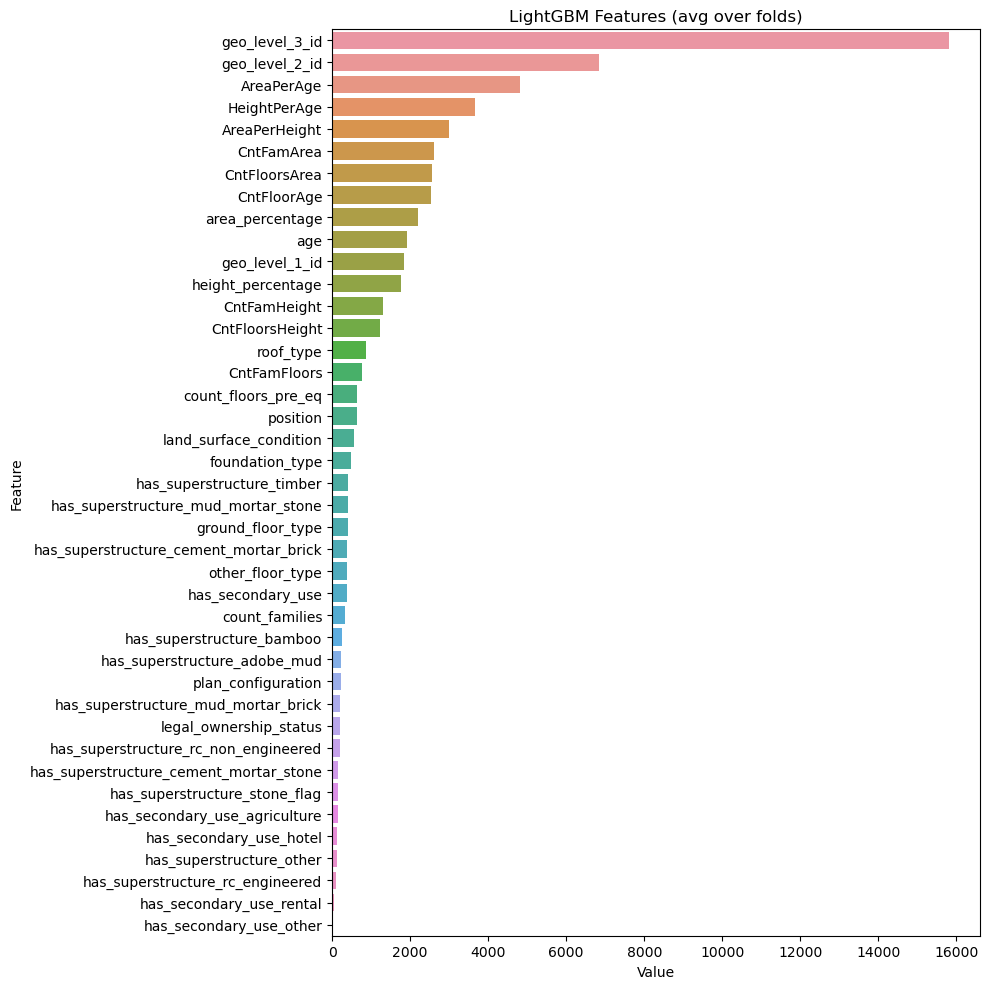

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [30]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

model_cm = lgb.LGBMClassifier(**study.best_params)
model_cm.fit(X_train, y_train)
preds1 = model_cm.predict(X_test)
cm = confusion_matrix(y_test, preds1)
print('Confusion matrix\n\n', cm)

[LightGBM] [Warning] feature_fraction is set=0.44790012898348197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44790012898348197
[LightGBM] [Warning] bagging_fraction is set=0.8839602086352771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839602086352771
[LightGBM] [Warning] lambda_l1 is set=6.791477848292383e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.791477848292383e-06
[LightGBM] [Warning] lambda_l2 is set=8.874795350903507e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.874795350903507e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.44790012898348197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44790012898348197
[LightGBM] [Warning] bagging_fraction is set=0.8839602086352771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839602086352771
[LightG

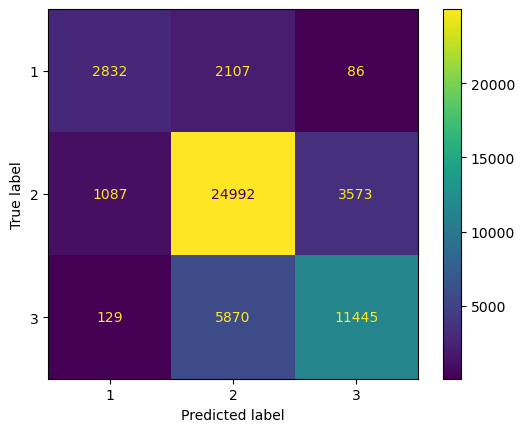

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds1, labels=model_cm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=model_cm.classes_)
disp.plot()

In [56]:
print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           1       0.70      0.56      0.62      5025
           2       0.76      0.84      0.80     29652
           3       0.76      0.66      0.70     17444

    accuracy                           0.75     52121
   macro avg       0.74      0.69      0.71     52121
weighted avg       0.75      0.75      0.75     52121



In [18]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

SEED = 42

np.random.seed(SEED)

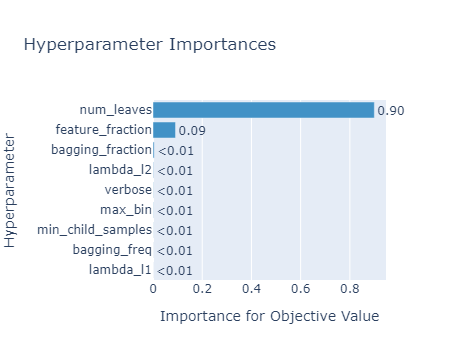

In [24]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

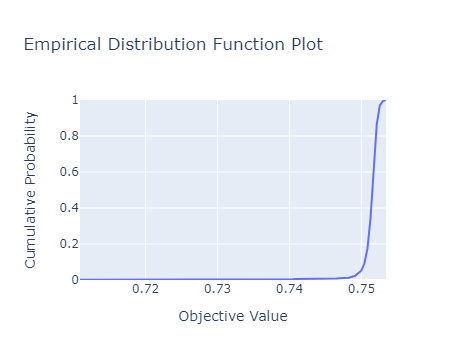

In [20]:
plot_edf(study)

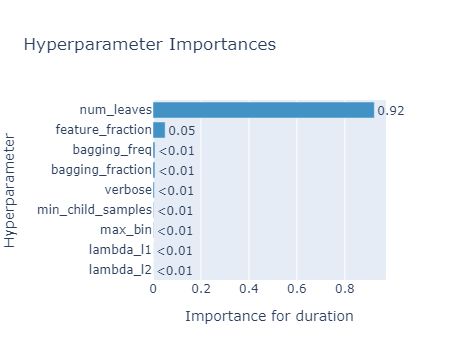

In [21]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

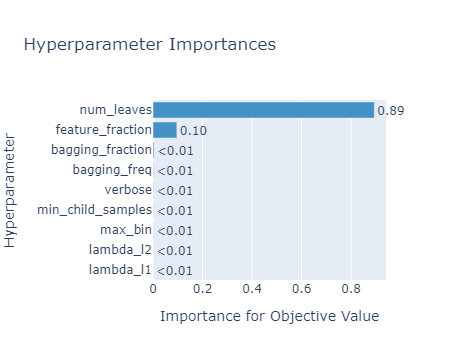

In [22]:
plot_param_importances(study)

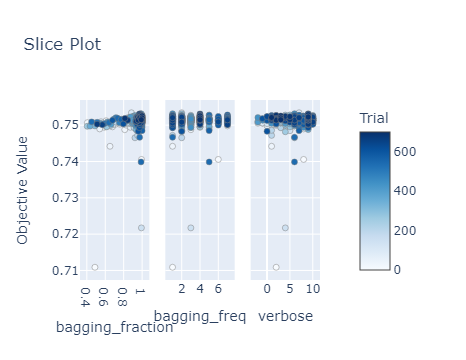

In [28]:
#plot_slice(study, params=["num_leaves","feature_fraction","bagging_fraction","bagging_freq","verbose","max_bin","min_child_samples","lambda_l1","lambda_l2"])

#plot_slice(study, params=["num_leaves","feature_fraction","bagging_fraction","bagging_freq","verbose","max_bin","min_child_samples","lambda_l1","lambda_l2"])


#plot_slice(study, params=["feature_fraction","num_leaves"])
plot_slice(study, params=["bagging_fraction","bagging_freq","verbose"])
# "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 0.0001, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 0.001, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 150),
#         #new setting 
#         'verbose': trial.suggest_int('verbose', -2, 10), 
#         'max_bin': trial.suggest_int('max_bin', 80, 2000)

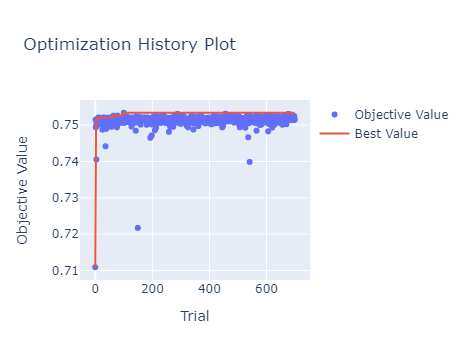

In [25]:
optuna.visualization.plot_optimization_history(study)